# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import cohen_kappa_fn, f1_fn
from models import FlexCNNClassifier
from torch import nn
from optim_utils import build_optimizer_and_scheduler
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [3]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

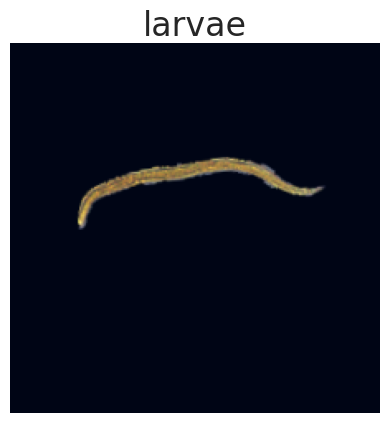

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [11]:
optim_config_0 = {
    "lr": 1e-3,
    "scheduler": "cosine",
    "weight_decay": 2e-4,
    "warmup_epochs": 10,
    "eta_min": 1e-6,
}
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(cnn_0, optim_config_0, total_epochs=100)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 1.2338 | Val Loss: 0.6695 | Train cohen_kappa_fn: 0.1214 | Val cohen_kappa_fn: 0.0376 | Train f1_fn: 0.8372 | Val f1_fn: 0.8869
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.8807 | Val Loss: 0.6992 | Train cohen_kappa_fn: 0.1885 | Val cohen_kappa_fn: 0.0588 | Train f1_fn: 0.9092 | Val f1_fn: 0.9165
  ❄️ No improvement, model won't be saved!


📘 Epoch 3 | Train Loss: 0.7139 | Val Loss: 0.6066 | Train cohen_kappa_fn: 0.1663 | Val cohen_kappa_fn: 0.1750 | Train f1_fn: 0.6033 | Val f1_fn: 0.6930
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5535 | Val Loss: 0.5663 | Train cohen_kappa_fn: 0.0716 | Val cohen_kappa_fn: 0.1161 | Train f1_fn: 0.3333 | Val f1_fn: 0.4732
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4653 | Val Loss: 0.5735 | Train cohen_kappa_fn: 0.0933 | Val cohen_kappa_fn: 0.1274 | Train f1_fn: 0.4005 | Val f1_fn: 0.4831
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3682 | Val Loss: 0.6827 | Train cohen_kappa_fn: 0.1085 | Val cohen_kappa_fn: 0.1145 | Train f1_fn: 0.4411 | Val f1_fn: 0.4527
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.3342 | Val Loss: 0.9094 | Train cohen_kappa_fn: 0.0753 | Val cohen_kappa_fn: 0.0694 | Train f1_fn: 0.3456 | Val f1_fn: 0.3230
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.3056 | Val Loss: 1.5178 | Train cohen_kappa_fn: 0.0156 | Val cohen_kappa_fn: 0.0156 | Train f1_fn: 0.0932 | Val f1_fn: 0.0919
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2376 | Val Loss: 1.0077 | Train cohen_kappa_fn: 0.0709 | Val cohen_kappa_fn: 0.0603 | Train f1_fn: 0.3313 | Val f1_fn: 0.2911
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


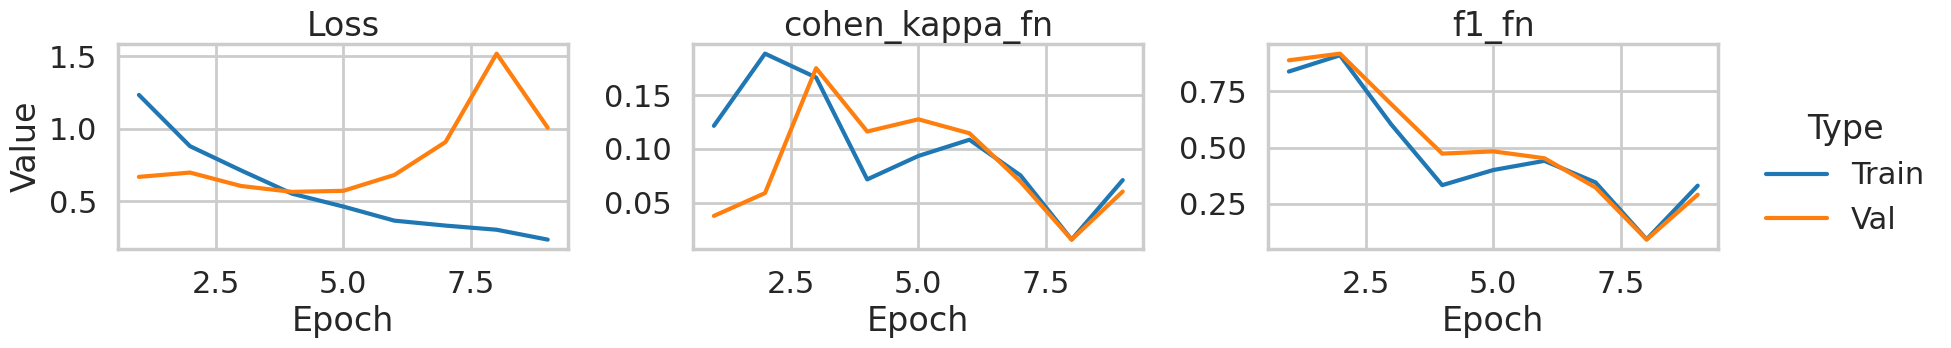

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.5584 | Test cohen_kappa_fn: 0.1586 | Test f1_fn: 0.5500


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

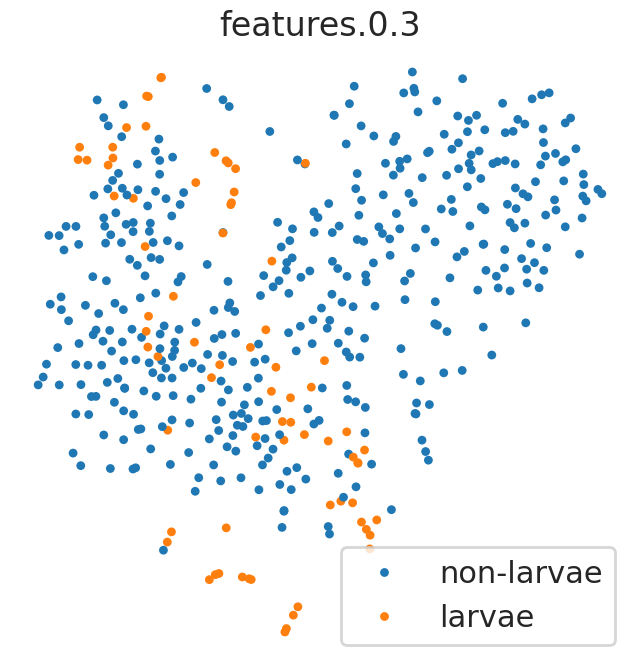

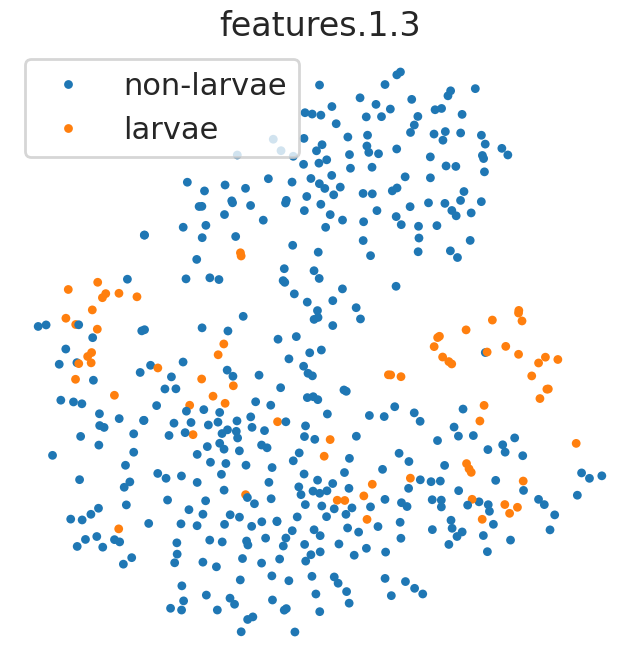

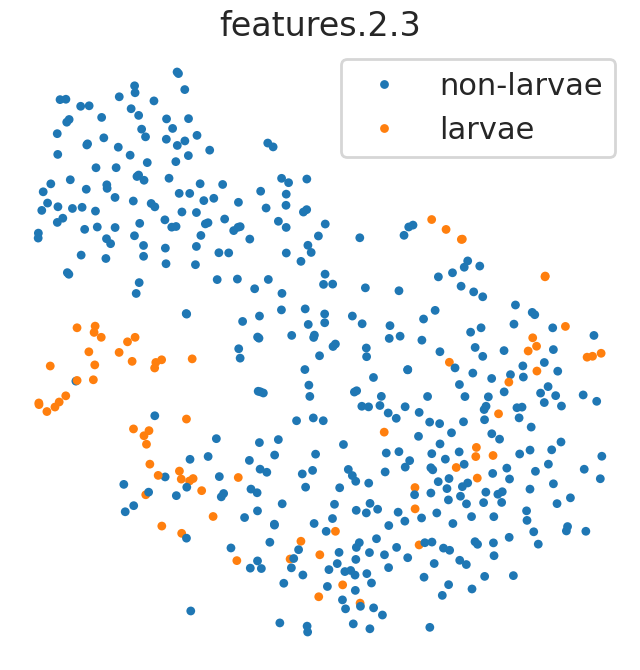

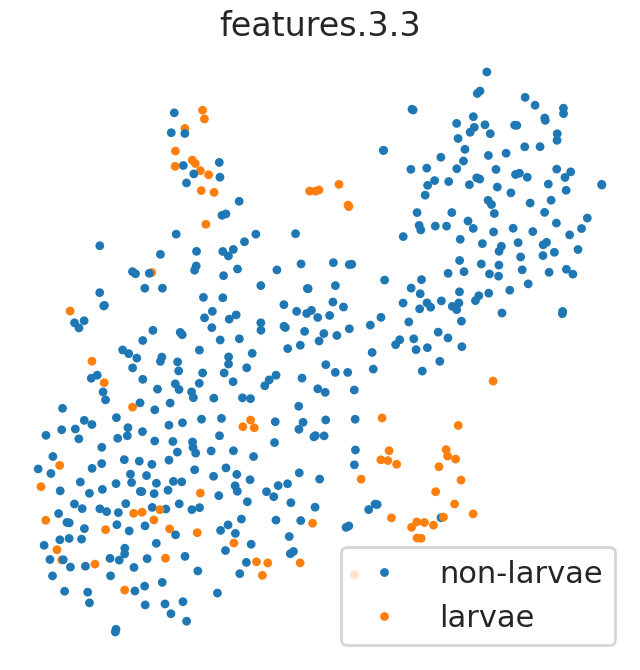

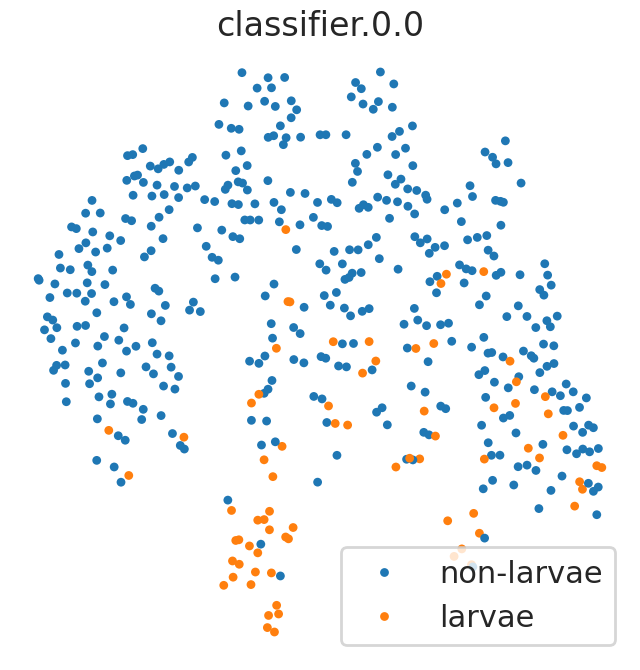

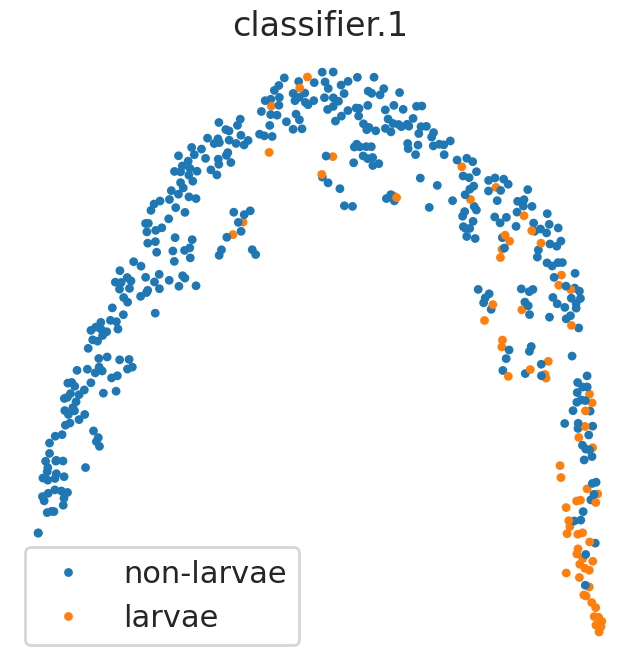

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


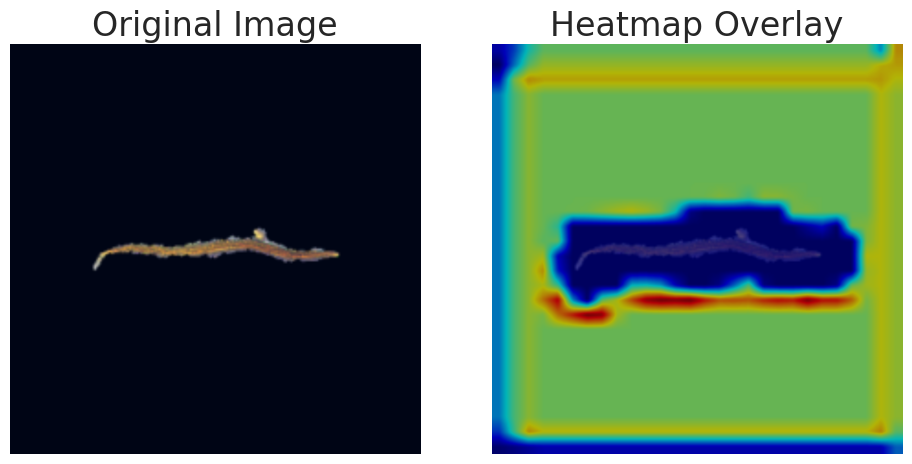

  Generating heatmap for Larvae...
  Predicted label is Larvae!


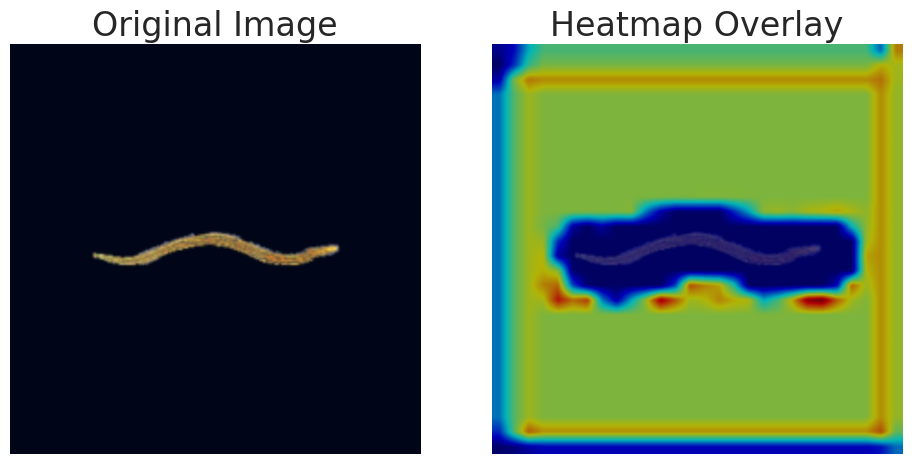

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [18]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [19]:
optim_config_1 = {
    "lr": 1e-4,
    "scheduler": "cosine",
    "weight_decay": 1e-4,
    "warmup_epochs": 10,
    "eta_min": 1e-6,
}
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(cnn_1, optim_config_1, total_epochs=100)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6889 | Val Loss: 0.6875 | Train cohen_kappa_fn: 0.0275 | Val cohen_kappa_fn: 0.2285 | Train f1_fn: 0.8851 | Val f1_fn: 0.9201
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6815 | Val Loss: 0.6823 | Train cohen_kappa_fn: 0.0333 | Val cohen_kappa_fn: 0.0957 | Train f1_fn: 0.2516 | Val f1_fn: 0.5081
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6701 | Val Loss: 0.6758 | Train cohen_kappa_fn: 0.1933 | Val cohen_kappa_fn: 0.3029 | Train f1_fn: 0.8472 | Val f1_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6537 | Val Loss: 0.6606 | Train cohen_kappa_fn: 0.1827 | Val cohen_kappa_fn: 0.2904 | Train f1_fn: 0.7036 | Val f1_fn: 0.8527
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6318 | Val Loss: 0.6387 | Train cohen_kappa_fn: 0.2516 | Val cohen_kappa_fn: 0.3587 | Train f1_fn: 0.8183 | Val f1_fn: 0.9301
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5997 | Val Loss: 0.6090 | Train cohen_kappa_fn: 0.2321 | Val cohen_kappa_fn: 0.3551 | Train f1_fn: 0.7798 | Val f1_fn: 0.9261
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5735 | Val Loss: 0.5959 | Train cohen_kappa_fn: 0.3523 | Val cohen_kappa_fn: 0.3202 | Train f1_fn: 0.8462 | Val f1_fn: 0.9287
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5375 | Val Loss: 0.5325 | Train cohen_kappa_fn: 0.3145 | Val cohen_kappa_fn: 0.5095 | Train f1_fn: 0.7827 | Val f1_fn: 0.9331
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5059 | Val Loss: 0.5169 | Train cohen_kappa_fn: 0.3713 | Val cohen_kappa_fn: 0.5271 | Train f1_fn: 0.8401 | Val f1_fn: 0.9348
  🔥 New best model saved!


/home/giovanne/personal/masters/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


📘 Epoch 10 | Train Loss: 0.4815 | Val Loss: 0.4557 | Train cohen_kappa_fn: 0.2708 | Val cohen_kappa_fn: 0.4283 | Train f1_fn: 0.7218 | Val f1_fn: 0.8470
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4355 | Val Loss: 0.4133 | Train cohen_kappa_fn: 0.4136 | Val cohen_kappa_fn: 0.5294 | Train f1_fn: 0.8357 | Val f1_fn: 0.8964
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3793 | Val Loss: 0.3823 | Train cohen_kappa_fn: 0.5006 | Val cohen_kappa_fn: 0.5997 | Train f1_fn: 0.8833 | Val f1_fn: 0.9251
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3585 | Val Loss: 0.3786 | Train cohen_kappa_fn: 0.6434 | Val cohen_kappa_fn: 0.6591 | Train f1_fn: 0.9300 | Val f1_fn: 0.9462
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3329 | Val Loss: 0.3520 | Train cohen_kappa_fn: 0.6435 | Val cohen_kappa_fn: 0.6463 | Train f1_fn: 0.9320 | Val f1_fn: 0.9374
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3015 | Val Loss: 0.3218 | Train cohen_kappa_fn: 0.5931 | Val cohen_kappa_fn: 0.5356 | Train f1_fn: 0.9127 | Val f1_fn: 0.8986
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2958 | Val Loss: 0.3165 | Train cohen_kappa_fn: 0.7785 | Val cohen_kappa_fn: 0.7062 | Train f1_fn: 0.9632 | Val f1_fn: 0.9513
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3119 | Val Loss: 0.3594 | Train cohen_kappa_fn: 0.4812 | Val cohen_kappa_fn: 0.4297 | Train f1_fn: 0.8615 | Val f1_fn: 0.8439
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2781 | Val Loss: 0.2815 | Train cohen_kappa_fn: 0.7979 | Val cohen_kappa_fn: 0.7019 | Train f1_fn: 0.9671 | Val f1_fn: 0.9492
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2408 | Val Loss: 0.2724 | Train cohen_kappa_fn: 0.7596 | Val cohen_kappa_fn: 0.6458 | Train f1_fn: 0.9574 | Val f1_fn: 0.9326
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2359 | Val Loss: 0.2524 | Train cohen_kappa_fn: 0.7902 | Val cohen_kappa_fn: 0.7645 | Train f1_fn: 0.9636 | Val f1_fn: 0.9606
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2284 | Val Loss: 0.2474 | Train cohen_kappa_fn: 0.7625 | Val cohen_kappa_fn: 0.6937 | Train f1_fn: 0.9573 | Val f1_fn: 0.9448
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1974 | Val Loss: 0.2669 | Train cohen_kappa_fn: 0.8629 | Val cohen_kappa_fn: 0.7901 | Train f1_fn: 0.9784 | Val f1_fn: 0.9665
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1927 | Val Loss: 0.3428 | Train cohen_kappa_fn: 0.4738 | Val cohen_kappa_fn: 0.4415 | Train f1_fn: 0.8552 | Val f1_fn: 0.8426
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2392 | Val Loss: 0.3790 | Train cohen_kappa_fn: 0.8205 | Val cohen_kappa_fn: 0.7526 | Train f1_fn: 0.9744 | Val f1_fn: 0.9655
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1989 | Val Loss: 0.2727 | Train cohen_kappa_fn: 0.6569 | Val cohen_kappa_fn: 0.5773 | Train f1_fn: 0.9261 | Val f1_fn: 0.9062
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1810 | Val Loss: 0.2557 | Train cohen_kappa_fn: 0.8319 | Val cohen_kappa_fn: 0.7381 | Train f1_fn: 0.9713 | Val f1_fn: 0.9570
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


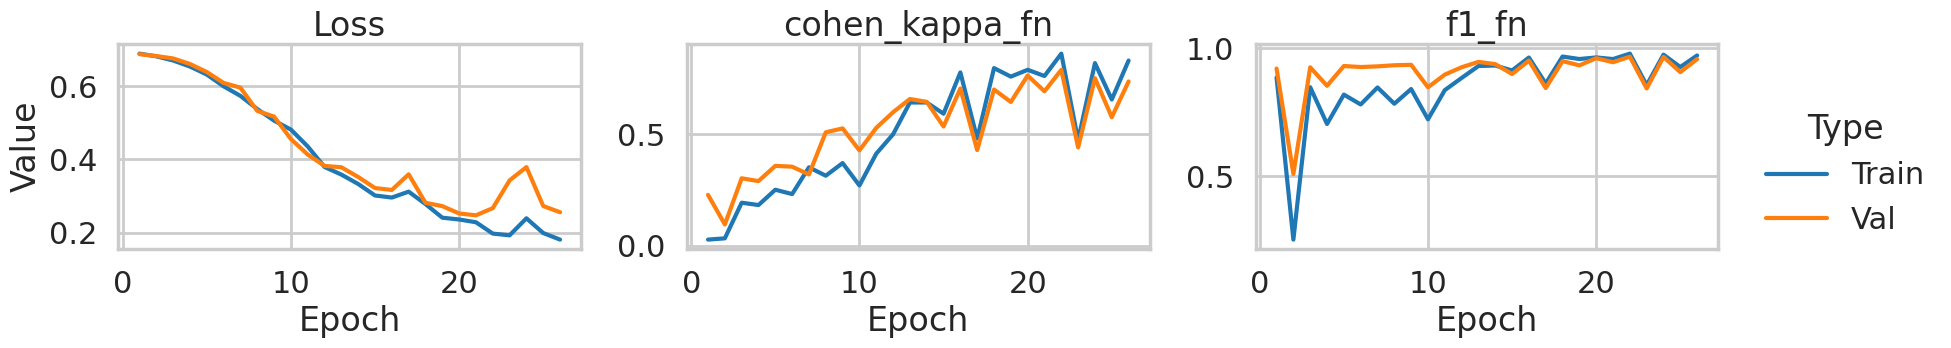

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2392 | Test cohen_kappa_fn: 0.8011 | Test f1_fn: 0.9677


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

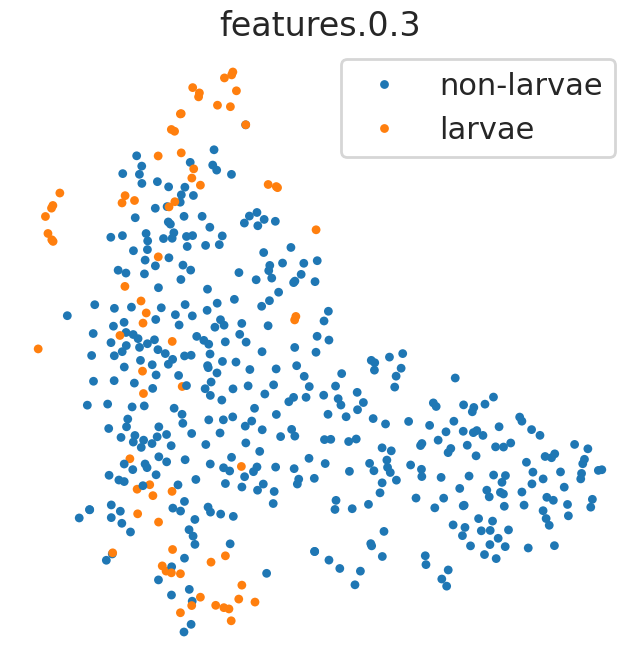

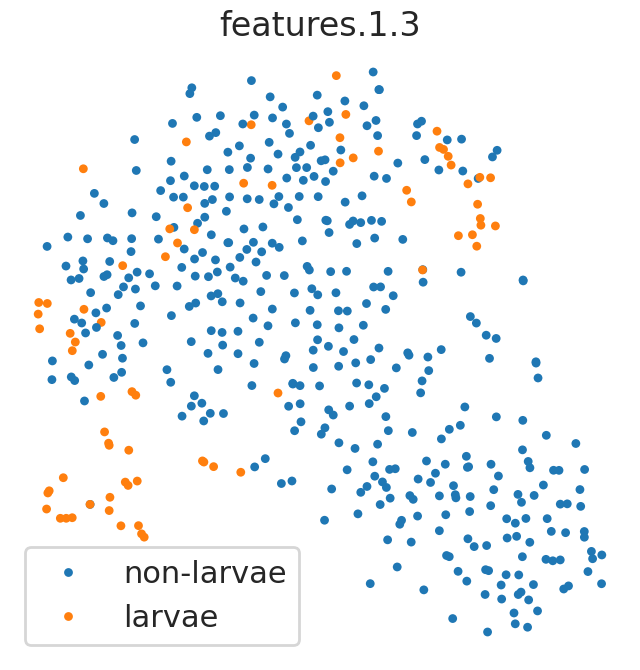

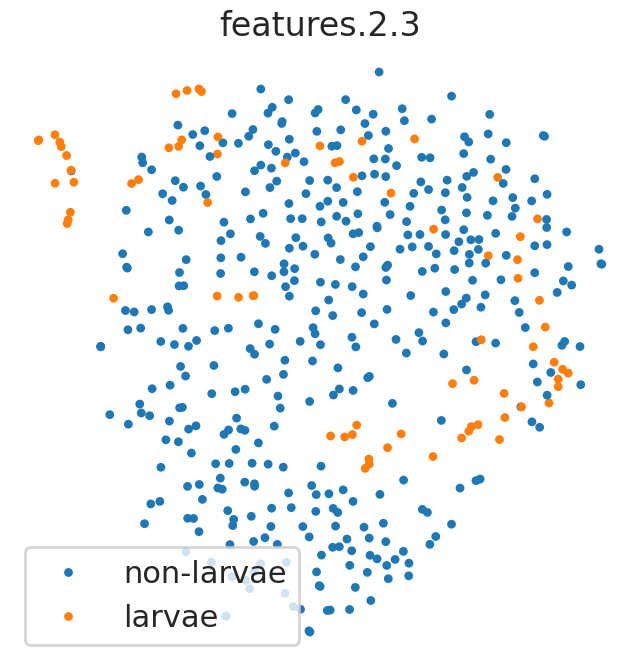

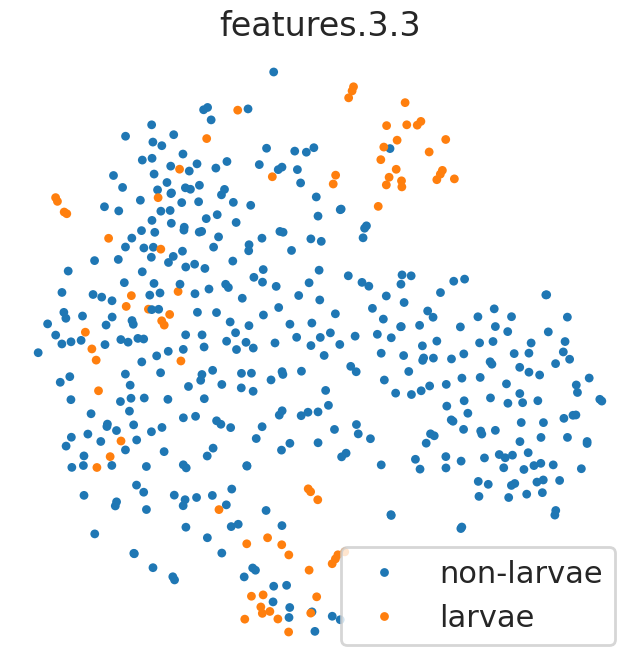

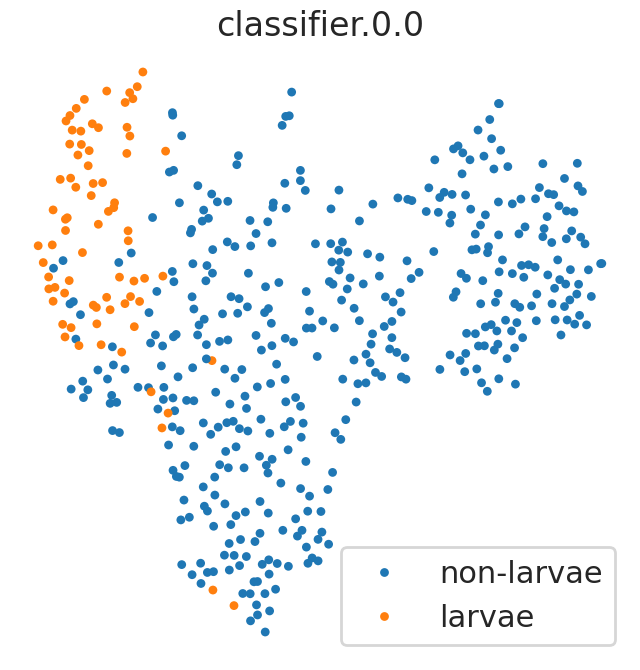

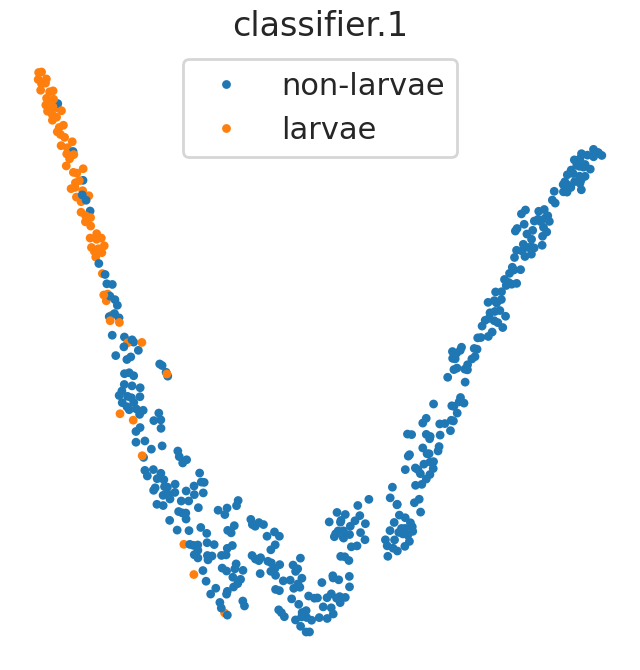

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


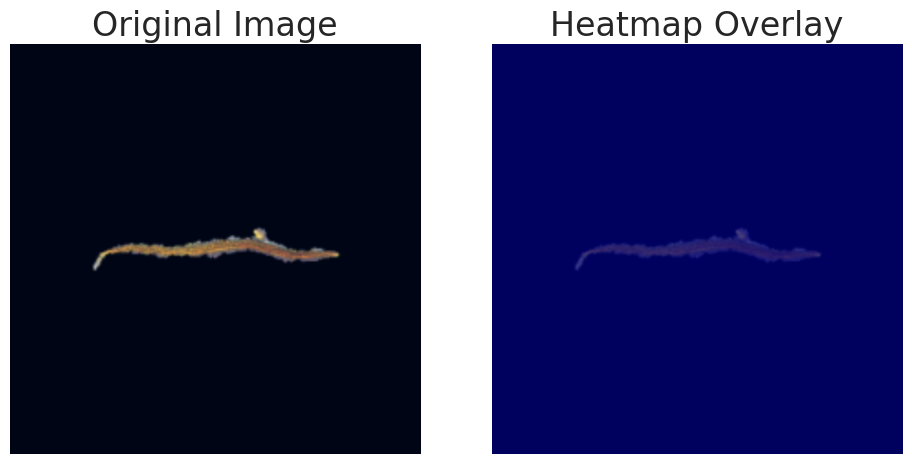

  Generating heatmap for Larvae...
  Predicted label is Larvae!


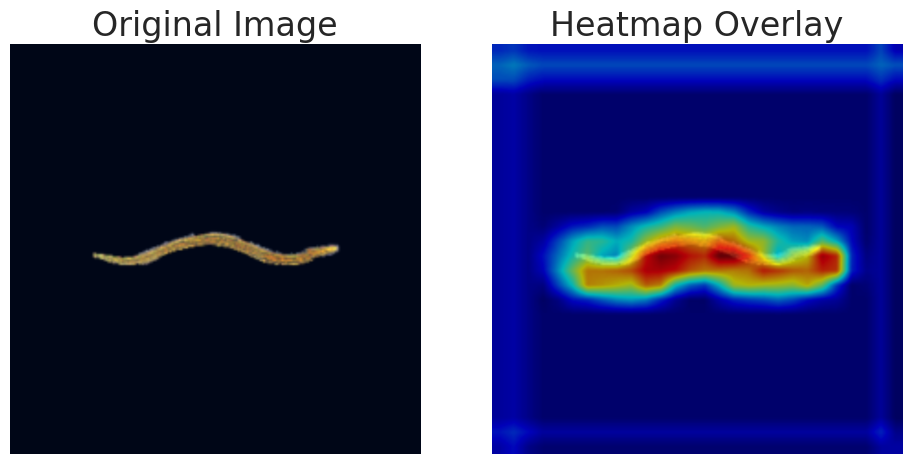

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [27]:
optim_config_2 = {
    "lr": 5e-5,
    "scheduler": "cosine",
    "weight_decay": 4e-4,
    "warmup_epochs": 10,
    "eta_min": 1e-6,
}
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(cnn_2, optim_config_2, total_epochs=100)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6897 | Val Loss: 0.6915 | Train cohen_kappa_fn: 0.0547 | Val cohen_kappa_fn: 0.1111 | Train f1_fn: 0.7862 | Val f1_fn: 0.8853
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6862 | Val Loss: 0.6899 | Train cohen_kappa_fn: 0.0696 | Val cohen_kappa_fn: 0.0791 | Train f1_fn: 0.6715 | Val f1_fn: 0.8247
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6791 | Val Loss: 0.6854 | Train cohen_kappa_fn: 0.0719 | Val cohen_kappa_fn: 0.0728 | Train f1_fn: 0.5460 | Val f1_fn: 0.6268
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6711 | Val Loss: 0.6761 | Train cohen_kappa_fn: 0.1003 | Val cohen_kappa_fn: 0.1464 | Train f1_fn: 0.6239 | Val f1_fn: 0.7715
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6575 | Val Loss: 0.6650 | Train cohen_kappa_fn: 0.2016 | Val cohen_kappa_fn: 0.0931 | Train f1_fn: 0.7737 | Val f1_fn: 0.8409
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6438 | Val Loss: 0.6486 | Train cohen_kappa_fn: 0.2420 | Val cohen_kappa_fn: 0.1142 | Train f1_fn: 0.7871 | Val f1_fn: 0.8518
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6206 | Val Loss: 0.6323 | Train cohen_kappa_fn: 0.2193 | Val cohen_kappa_fn: 0.1525 | Train f1_fn: 0.7553 | Val f1_fn: 0.8429
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5962 | Val Loss: 0.6188 | Train cohen_kappa_fn: 0.1898 | Val cohen_kappa_fn: 0.1701 | Train f1_fn: 0.7217 | Val f1_fn: 0.8320
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5826 | Val Loss: 0.6050 | Train cohen_kappa_fn: 0.2366 | Val cohen_kappa_fn: 0.1871 | Train f1_fn: 0.7694 | Val f1_fn: 0.8411
  🔥 New best model saved!


/home/giovanne/personal/masters/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


📘 Epoch 10 | Train Loss: 0.5853 | Val Loss: 0.5835 | Train cohen_kappa_fn: 0.2840 | Val cohen_kappa_fn: 0.2664 | Train f1_fn: 0.7768 | Val f1_fn: 0.8566
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.5653 | Val Loss: 0.5592 | Train cohen_kappa_fn: 0.2811 | Val cohen_kappa_fn: 0.2904 | Train f1_fn: 0.7746 | Val f1_fn: 0.8527
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.5446 | Val Loss: 0.5709 | Train cohen_kappa_fn: 0.4098 | Val cohen_kappa_fn: 0.3769 | Train f1_fn: 0.8708 | Val f1_fn: 0.9017
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.5154 | Val Loss: 0.5010 | Train cohen_kappa_fn: 0.2669 | Val cohen_kappa_fn: 0.3112 | Train f1_fn: 0.7298 | Val f1_fn: 0.8184
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.4982 | Val Loss: 0.5107 | Train cohen_kappa_fn: 0.3854 | Val cohen_kappa_fn: 0.3592 | Train f1_fn: 0.8489 | Val f1_fn: 0.8812
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.4690 | Val Loss: 0.4599 | Train cohen_kappa_fn: 0.3455 | Val cohen_kappa_fn: 0.3544 | Train f1_fn: 0.8000 | Val f1_fn: 0.8508
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.4599 | Val Loss: 0.4589 | Train cohen_kappa_fn: 0.4189 | Val cohen_kappa_fn: 0.4483 | Train f1_fn: 0.8526 | Val f1_fn: 0.8987
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.4309 | Val Loss: 0.4558 | Train cohen_kappa_fn: 0.5166 | Val cohen_kappa_fn: 0.5180 | Train f1_fn: 0.8980 | Val f1_fn: 0.9239
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.4201 | Val Loss: 0.4114 | Train cohen_kappa_fn: 0.4713 | Val cohen_kappa_fn: 0.5176 | Train f1_fn: 0.8737 | Val f1_fn: 0.9098
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.4032 | Val Loss: 0.3991 | Train cohen_kappa_fn: 0.4677 | Val cohen_kappa_fn: 0.5176 | Train f1_fn: 0.8696 | Val f1_fn: 0.9098
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.4017 | Val Loss: 0.3837 | Train cohen_kappa_fn: 0.5097 | Val cohen_kappa_fn: 0.5532 | Train f1_fn: 0.8880 | Val f1_fn: 0.9202
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.3935 | Val Loss: 0.3637 | Train cohen_kappa_fn: 0.5191 | Val cohen_kappa_fn: 0.5697 | Train f1_fn: 0.8883 | Val f1_fn: 0.9144
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.3505 | Val Loss: 0.3724 | Train cohen_kappa_fn: 0.6510 | Val cohen_kappa_fn: 0.6815 | Train f1_fn: 0.9365 | Val f1_fn: 0.9522
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.3563 | Val Loss: 0.3292 | Train cohen_kappa_fn: 0.4994 | Val cohen_kappa_fn: 0.4944 | Train f1_fn: 0.8734 | Val f1_fn: 0.8803
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.3278 | Val Loss: 0.3365 | Train cohen_kappa_fn: 0.7291 | Val cohen_kappa_fn: 0.7296 | Train f1_fn: 0.9530 | Val f1_fn: 0.9573
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.3022 | Val Loss: 0.3141 | Train cohen_kappa_fn: 0.6709 | Val cohen_kappa_fn: 0.6596 | Train f1_fn: 0.9375 | Val f1_fn: 0.9392
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.2840 | Val Loss: 0.3111 | Train cohen_kappa_fn: 0.7222 | Val cohen_kappa_fn: 0.7153 | Train f1_fn: 0.9524 | Val f1_fn: 0.9533
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2895 | Val Loss: 0.2822 | Train cohen_kappa_fn: 0.6864 | Val cohen_kappa_fn: 0.6284 | Train f1_fn: 0.9376 | Val f1_fn: 0.9261
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2614 | Val Loss: 0.2852 | Train cohen_kappa_fn: 0.7185 | Val cohen_kappa_fn: 0.7107 | Train f1_fn: 0.9506 | Val f1_fn: 0.9511
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2709 | Val Loss: 0.2666 | Train cohen_kappa_fn: 0.6768 | Val cohen_kappa_fn: 0.6818 | Train f1_fn: 0.9361 | Val f1_fn: 0.9405
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.2612 | Val Loss: 0.2608 | Train cohen_kappa_fn: 0.7265 | Val cohen_kappa_fn: 0.7063 | Train f1_fn: 0.9493 | Val f1_fn: 0.9490
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.2374 | Val Loss: 0.2586 | Train cohen_kappa_fn: 0.6479 | Val cohen_kappa_fn: 0.6284 | Train f1_fn: 0.9267 | Val f1_fn: 0.9261
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.2519 | Val Loss: 0.2629 | Train cohen_kappa_fn: 0.7420 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9534 | Val f1_fn: 0.9591
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2338 | Val Loss: 0.2538 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9452 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.2356 | Val Loss: 0.2504 | Train cohen_kappa_fn: 0.7440 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9543 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.2274 | Val Loss: 0.2432 | Train cohen_kappa_fn: 0.7197 | Val cohen_kappa_fn: 0.7064 | Train f1_fn: 0.9467 | Val f1_fn: 0.9466
  🔥 New best model saved!


📘 Epoch 36 | Train Loss: 0.2155 | Val Loss: 0.2445 | Train cohen_kappa_fn: 0.7348 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9508 | Val f1_fn: 0.9526
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.2115 | Val Loss: 0.2707 | Train cohen_kappa_fn: 0.7849 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9648 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.2197 | Val Loss: 0.2397 | Train cohen_kappa_fn: 0.7490 | Val cohen_kappa_fn: 0.6973 | Train f1_fn: 0.9550 | Val f1_fn: 0.9493
  🔥 New best model saved!


📘 Epoch 39 | Train Loss: 0.2024 | Val Loss: 0.2353 | Train cohen_kappa_fn: 0.6974 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9400 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 40 | Train Loss: 0.1978 | Val Loss: 0.2309 | Train cohen_kappa_fn: 0.7329 | Val cohen_kappa_fn: 0.7151 | Train f1_fn: 0.9500 | Val f1_fn: 0.9509
  🔥 New best model saved!


📘 Epoch 41 | Train Loss: 0.1909 | Val Loss: 0.2333 | Train cohen_kappa_fn: 0.7784 | Val cohen_kappa_fn: 0.7409 | Train f1_fn: 0.9594 | Val f1_fn: 0.9545
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.1969 | Val Loss: 0.2344 | Train cohen_kappa_fn: 0.7807 | Val cohen_kappa_fn: 0.7288 | Train f1_fn: 0.9602 | Val f1_fn: 0.9551
  ❄️ No improvement, model won't be saved!


📘 Epoch 43 | Train Loss: 0.1898 | Val Loss: 0.2361 | Train cohen_kappa_fn: 0.7596 | Val cohen_kappa_fn: 0.7108 | Train f1_fn: 0.9555 | Val f1_fn: 0.9534
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.1850 | Val Loss: 0.2644 | Train cohen_kappa_fn: 0.8016 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9660 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.1851 | Val Loss: 0.2407 | Train cohen_kappa_fn: 0.8002 | Val cohen_kappa_fn: 0.7653 | Train f1_fn: 0.9651 | Val f1_fn: 0.9651
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


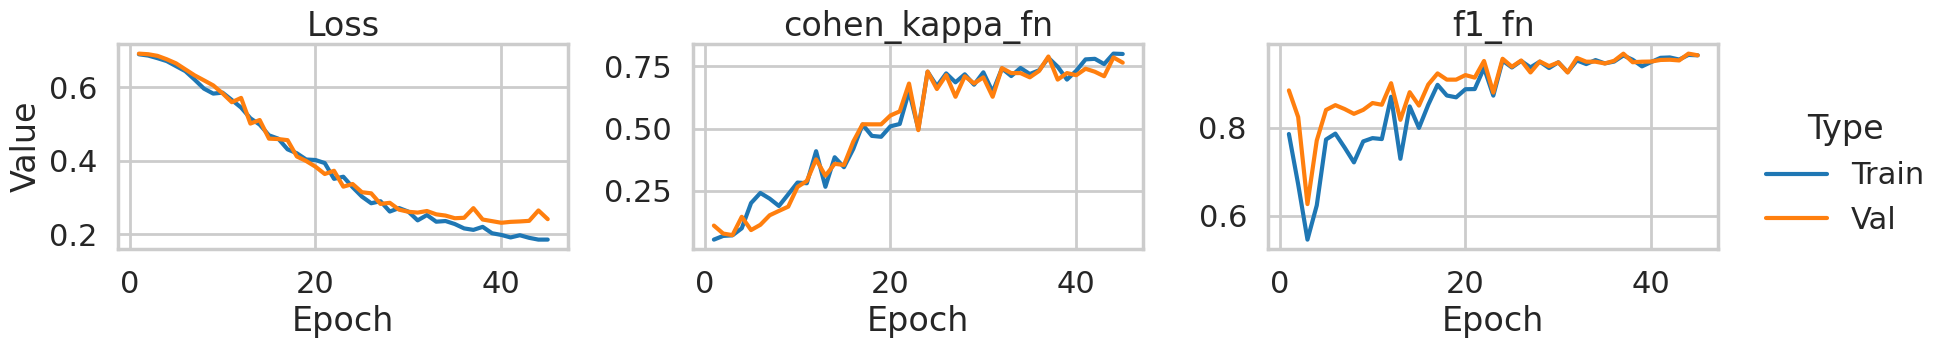

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2157 | Test cohen_kappa_fn: 0.7690 | Test f1_fn: 0.9612


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

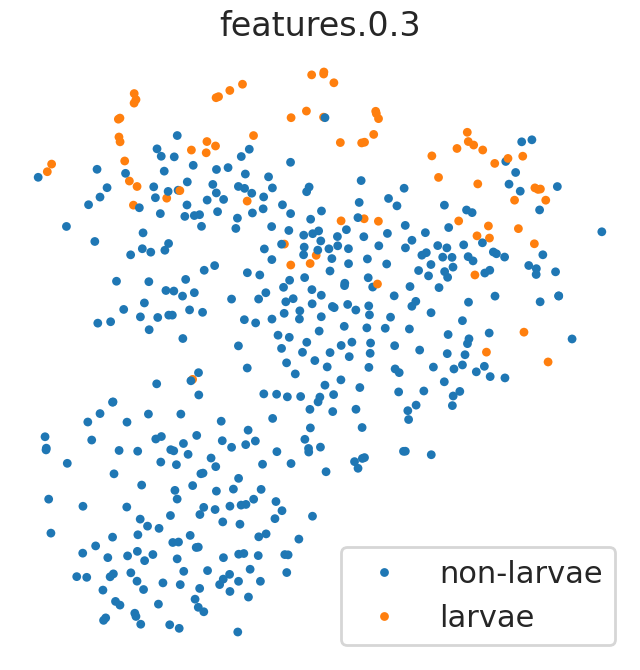

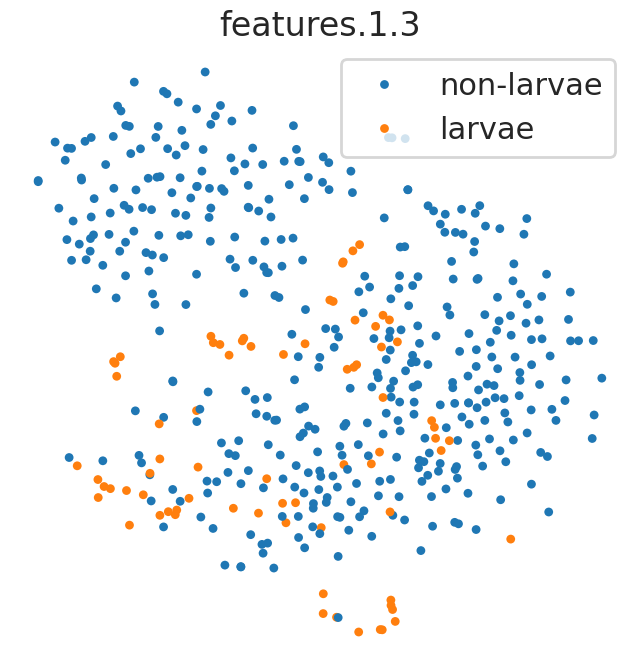

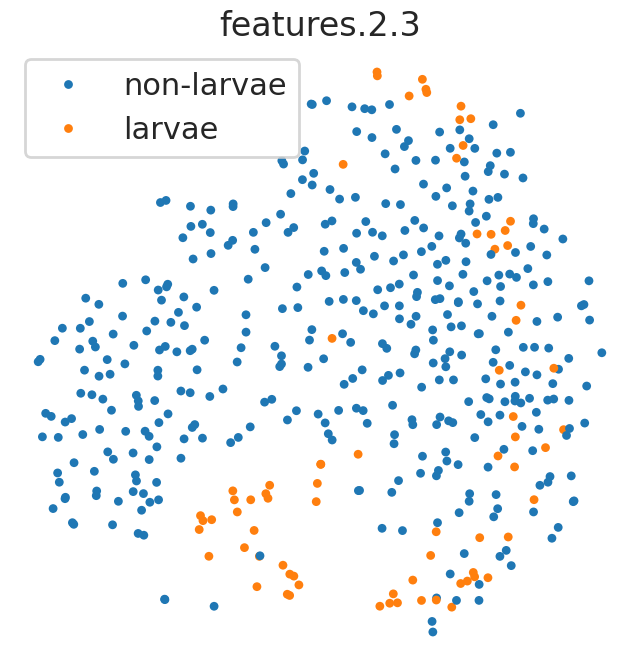

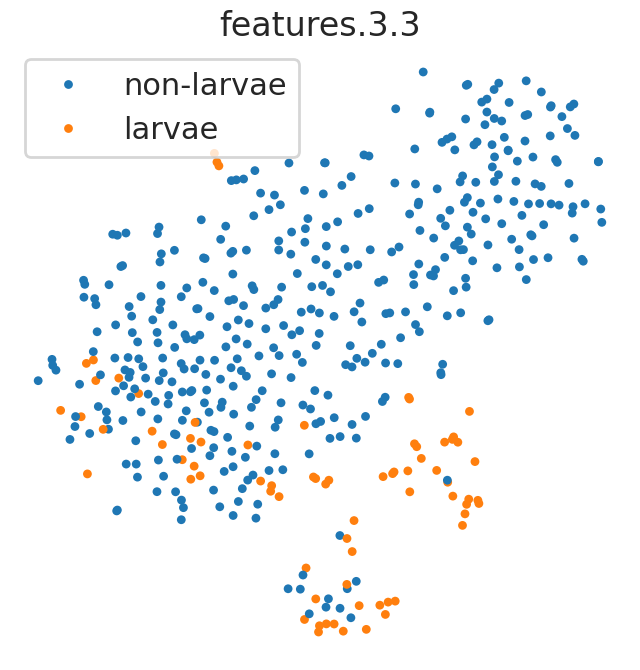

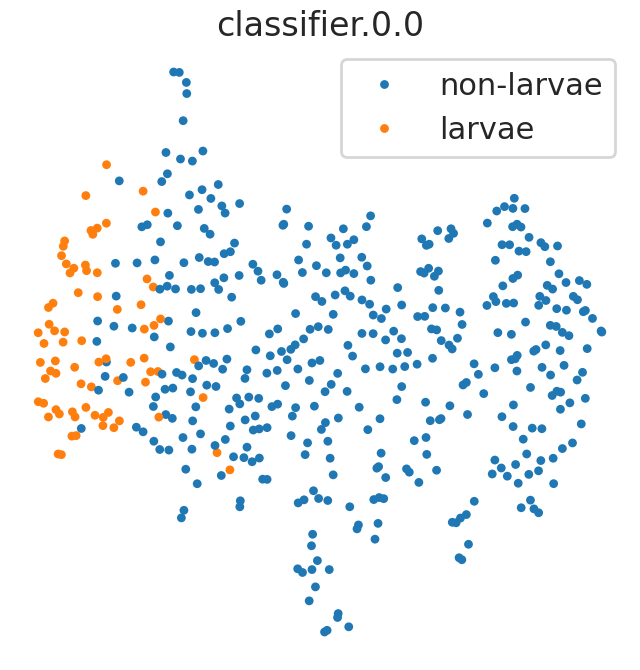

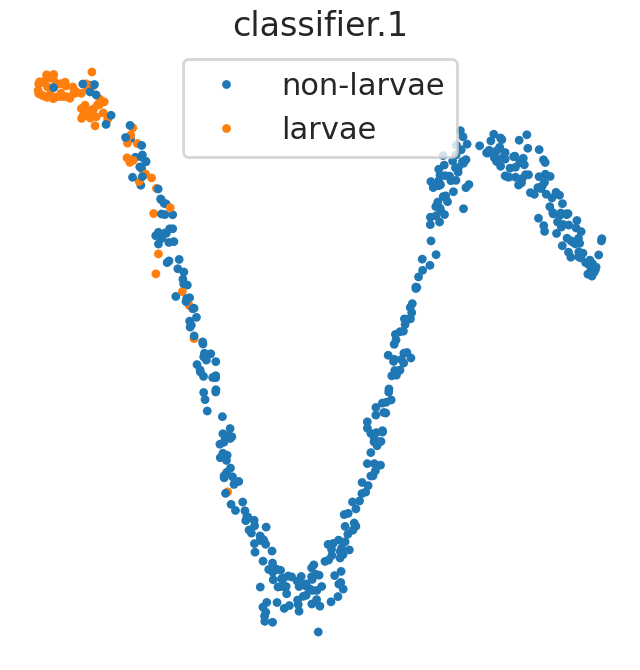

In [32]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


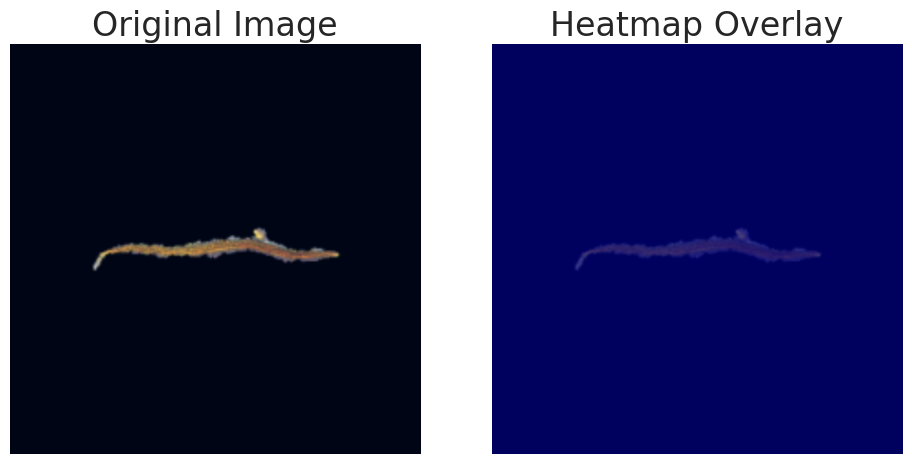

  Generating heatmap for Larvae...
  Predicted label is Larvae!


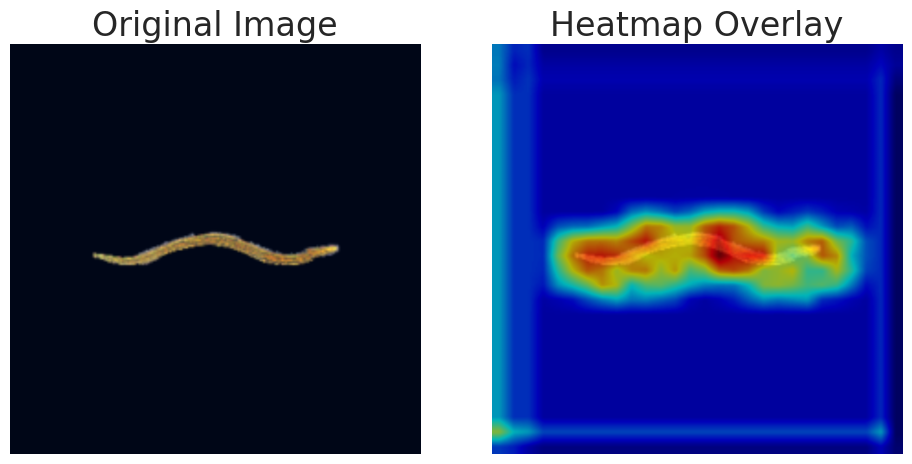

In [33]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [34]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [35]:
optim_config_3 = {
    "lr": 1e-4,
    "scheduler": "plateau",
    "weight_decay": 2e-4,
    "warmup_epochs": 10,
    "eta_min": 1e-6,
    "factor": 0.4,
    "patience": 2,
}
optimizer_cnn_3, scheduler_cnn_3 = build_optimizer_and_scheduler(cnn_3, optim_config_3, total_epochs=100)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [36]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6838 | Val Loss: 0.6868 | Train cohen_kappa_fn: 0.0593 | Val cohen_kappa_fn: -0.0484 | Train f1_fn: 0.8520 | Val f1_fn: 0.8783
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6612 | Val Loss: 0.6789 | Train cohen_kappa_fn: 0.1126 | Val cohen_kappa_fn: 0.1329 | Train f1_fn: 0.5913 | Val f1_fn: 0.7143
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6388 | Val Loss: 0.6682 | Train cohen_kappa_fn: 0.0595 | Val cohen_kappa_fn: 0.1138 | Train f1_fn: 0.2911 | Val f1_fn: 0.5000
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6334 | Val Loss: 0.6548 | Train cohen_kappa_fn: 0.2059 | Val cohen_kappa_fn: 0.1224 | Train f1_fn: 0.7622 | Val f1_fn: 0.8829
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6169 | Val Loss: 0.6483 | Train cohen_kappa_fn: 0.3064 | Val cohen_kappa_fn: 0.1635 | Train f1_fn: 0.8629 | Val f1_fn: 0.9191
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6034 | Val Loss: 0.6021 | Train cohen_kappa_fn: 0.1026 | Val cohen_kappa_fn: 0.2954 | Train f1_fn: 0.5329 | Val f1_fn: 0.8142
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5874 | Val Loss: 0.6478 | Train cohen_kappa_fn: 0.2934 | Val cohen_kappa_fn: 0.1876 | Train f1_fn: 0.8474 | Val f1_fn: 0.9148
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5654 | Val Loss: 0.5730 | Train cohen_kappa_fn: 0.2001 | Val cohen_kappa_fn: 0.3206 | Train f1_fn: 0.6900 | Val f1_fn: 0.8660
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5414 | Val Loss: 0.5692 | Train cohen_kappa_fn: 0.3001 | Val cohen_kappa_fn: 0.4194 | Train f1_fn: 0.8091 | Val f1_fn: 0.9225
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5150 | Val Loss: 0.5397 | Train cohen_kappa_fn: 0.2901 | Val cohen_kappa_fn: 0.4440 | Train f1_fn: 0.7910 | Val f1_fn: 0.9174
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4935 | Val Loss: 0.4878 | Train cohen_kappa_fn: 0.2670 | Val cohen_kappa_fn: 0.3471 | Train f1_fn: 0.7240 | Val f1_fn: 0.8644
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4601 | Val Loss: 0.5911 | Train cohen_kappa_fn: 0.4506 | Val cohen_kappa_fn: 0.4549 | Train f1_fn: 0.9026 | Val f1_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.4544 | Val Loss: 0.4503 | Train cohen_kappa_fn: 0.1478 | Val cohen_kappa_fn: 0.2490 | Train f1_fn: 0.5294 | Val f1_fn: 0.6797
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.4931 | Val Loss: 0.5483 | Train cohen_kappa_fn: 0.5632 | Val cohen_kappa_fn: 0.5594 | Train f1_fn: 0.9308 | Val f1_fn: 0.9489
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.4397 | Val Loss: 0.4197 | Train cohen_kappa_fn: 0.2709 | Val cohen_kappa_fn: 0.3325 | Train f1_fn: 0.7159 | Val f1_fn: 0.7785
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3955 | Val Loss: 0.4187 | Train cohen_kappa_fn: 0.4822 | Val cohen_kappa_fn: 0.4489 | Train f1_fn: 0.8782 | Val f1_fn: 0.8836
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3899 | Val Loss: 0.3930 | Train cohen_kappa_fn: 0.5469 | Val cohen_kappa_fn: 0.5003 | Train f1_fn: 0.8948 | Val f1_fn: 0.8798
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3399 | Val Loss: 0.3680 | Train cohen_kappa_fn: 0.4098 | Val cohen_kappa_fn: 0.4247 | Train f1_fn: 0.8253 | Val f1_fn: 0.8294
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3181 | Val Loss: 0.3371 | Train cohen_kappa_fn: 0.6280 | Val cohen_kappa_fn: 0.6035 | Train f1_fn: 0.9228 | Val f1_fn: 0.9225
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2822 | Val Loss: 0.3242 | Train cohen_kappa_fn: 0.6163 | Val cohen_kappa_fn: 0.5619 | Train f1_fn: 0.9215 | Val f1_fn: 0.9098
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2747 | Val Loss: 0.3043 | Train cohen_kappa_fn: 0.6120 | Val cohen_kappa_fn: 0.5864 | Train f1_fn: 0.9187 | Val f1_fn: 0.9134
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2630 | Val Loss: 0.2878 | Train cohen_kappa_fn: 0.5893 | Val cohen_kappa_fn: 0.5797 | Train f1_fn: 0.9056 | Val f1_fn: 0.9112
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2537 | Val Loss: 0.2757 | Train cohen_kappa_fn: 0.7450 | Val cohen_kappa_fn: 0.7730 | Train f1_fn: 0.9533 | Val f1_fn: 0.9649
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.2325 | Val Loss: 0.2586 | Train cohen_kappa_fn: 0.6384 | Val cohen_kappa_fn: 0.6892 | Train f1_fn: 0.9211 | Val f1_fn: 0.9450
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2335 | Val Loss: 0.3735 | Train cohen_kappa_fn: 0.7995 | Val cohen_kappa_fn: 0.7677 | Train f1_fn: 0.9688 | Val f1_fn: 0.9673
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2203 | Val Loss: 0.4040 | Train cohen_kappa_fn: 0.8124 | Val cohen_kappa_fn: 0.7216 | Train f1_fn: 0.9720 | Val f1_fn: 0.9620
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1931 | Val Loss: 0.2739 | Train cohen_kappa_fn: 0.7755 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9605 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1898 | Val Loss: 0.2687 | Train cohen_kappa_fn: 0.8051 | Val cohen_kappa_fn: 0.8147 | Train f1_fn: 0.9658 | Val f1_fn: 0.9725
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1716 | Val Loss: 0.2441 | Train cohen_kappa_fn: 0.7569 | Val cohen_kappa_fn: 0.7381 | Train f1_fn: 0.9536 | Val f1_fn: 0.9570
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1738 | Val Loss: 0.2702 | Train cohen_kappa_fn: 0.8241 | Val cohen_kappa_fn: 0.7969 | Train f1_fn: 0.9697 | Val f1_fn: 0.9686
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1524 | Val Loss: 0.2453 | Train cohen_kappa_fn: 0.7666 | Val cohen_kappa_fn: 0.7330 | Train f1_fn: 0.9571 | Val f1_fn: 0.9549
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1698 | Val Loss: 0.2687 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.8115 | Train f1_fn: 0.9738 | Val f1_fn: 0.9726
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1535 | Val Loss: 0.3930 | Train cohen_kappa_fn: 0.8242 | Val cohen_kappa_fn: 0.7373 | Train f1_fn: 0.9743 | Val f1_fn: 0.9638
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1663 | Val Loss: 0.3122 | Train cohen_kappa_fn: 0.8740 | Val cohen_kappa_fn: 0.7971 | Train f1_fn: 0.9799 | Val f1_fn: 0.9708
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


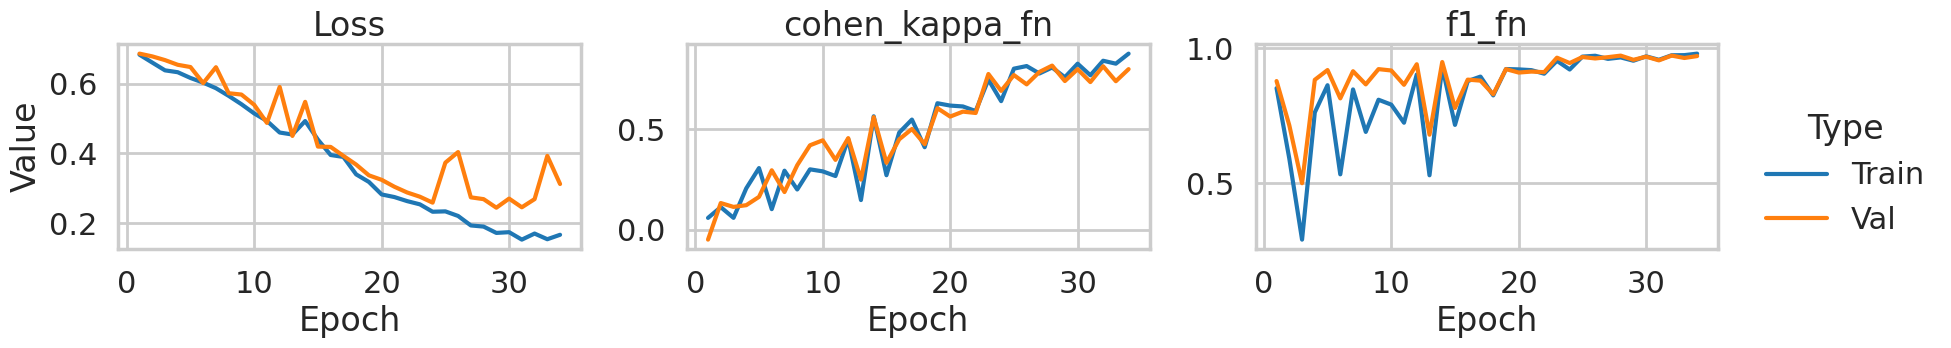

In [37]:
trainer_cnn_3.plot_epochs()

In [38]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2215 | Test cohen_kappa_fn: 0.7945 | Test f1_fn: 0.9664


#### Visualization

In [39]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

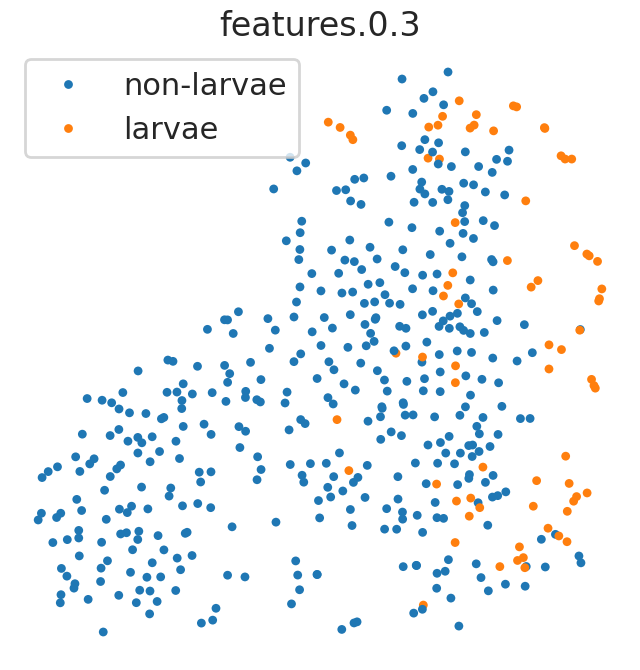

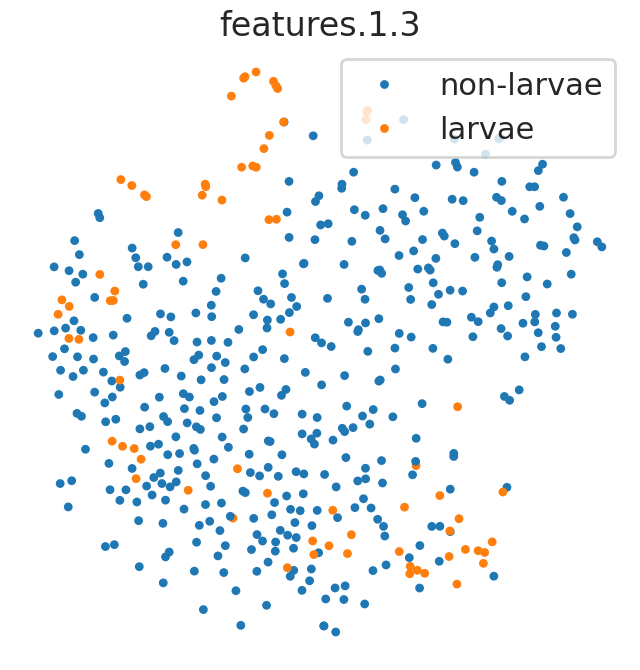

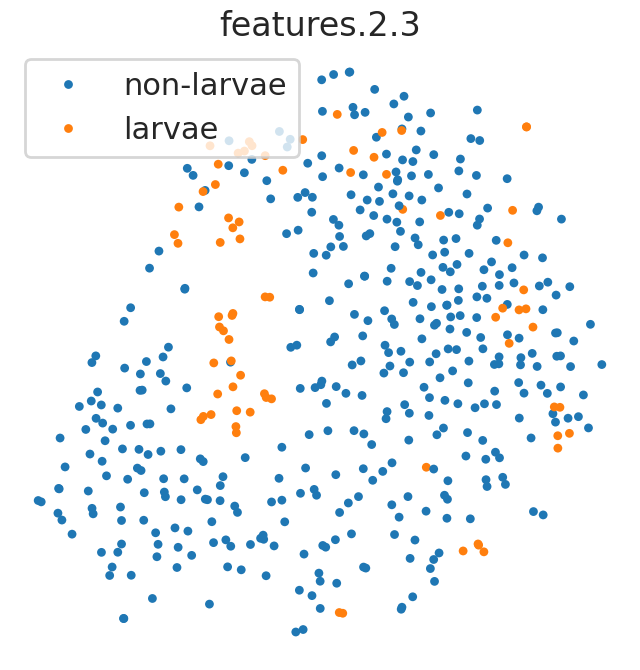

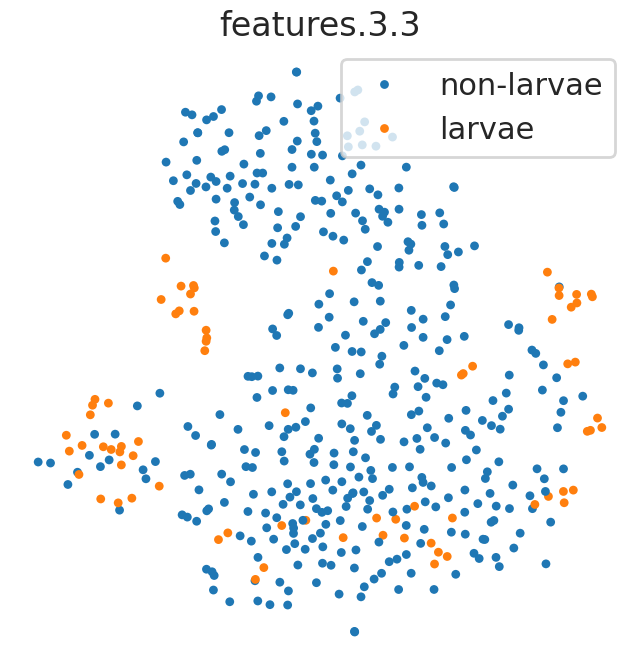

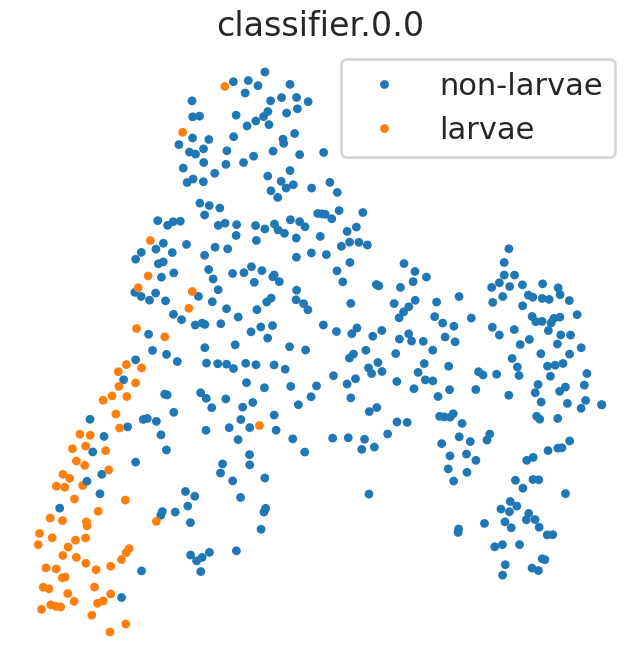

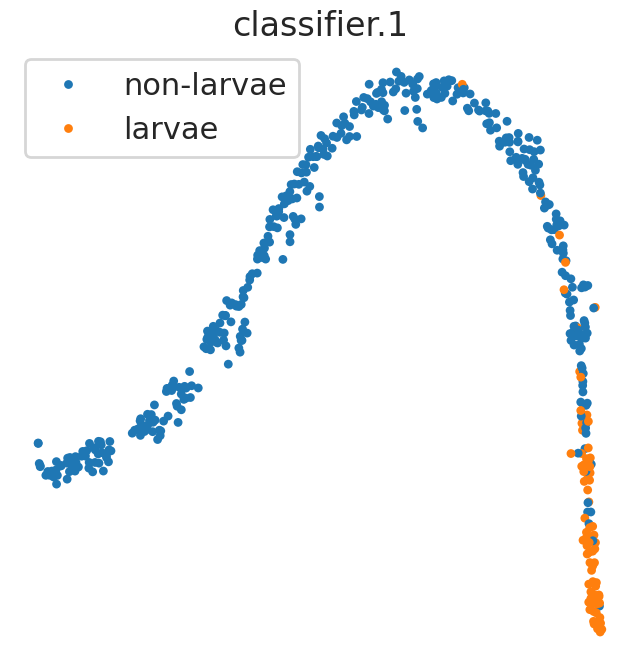

In [40]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


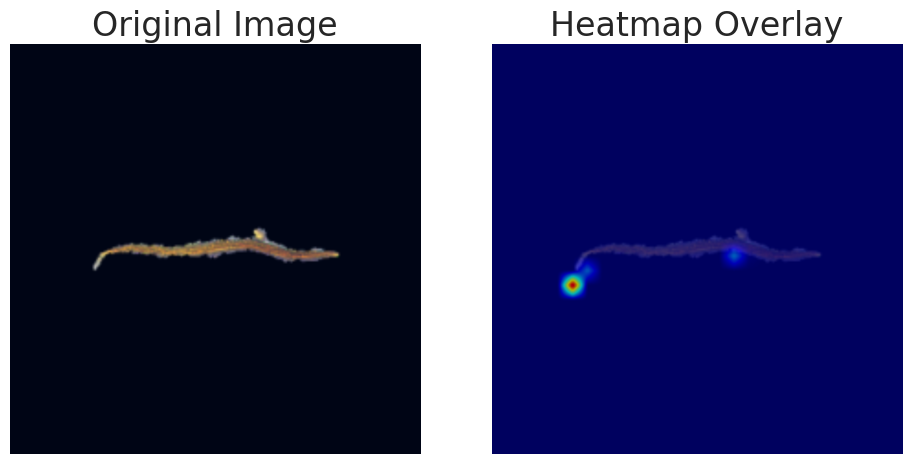

  Generating heatmap for Larvae...
  Predicted label is Larvae!


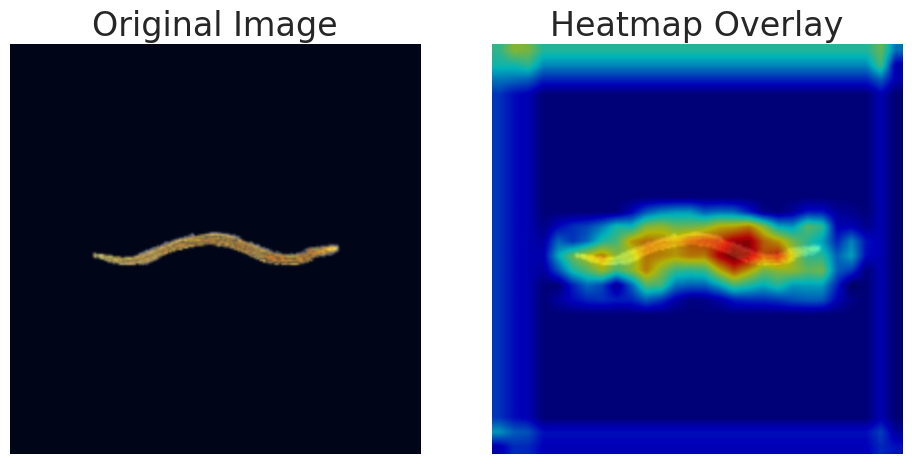

In [41]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [44]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [45]:
optim_config_4 = {
    "lr": 1e-4,
    "scheduler": "plateau",
    "weight_decay": 1e-4,
    "warmup_epochs": 10,
    "eta_min": 1e-6,
    "factor": 0.4,
    "patience": 2,
}
optimizer_cnn_4, scheduler_cnn_4 = build_optimizer_and_scheduler(cnn_4, optim_config_4, total_epochs=100)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=8,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [46]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.7012 | Val Loss: 0.6926 | Train cohen_kappa_fn: 0.0084 | Val cohen_kappa_fn: 0.0156 | Train f1_fn: 0.0519 | Val f1_fn: 0.0919
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6455 | Val Loss: 0.6842 | Train cohen_kappa_fn: 0.0503 | Val cohen_kappa_fn: 0.0467 | Train f1_fn: 0.2558 | Val f1_fn: 0.3148
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6358 | Val Loss: 0.6719 | Train cohen_kappa_fn: 0.0774 | Val cohen_kappa_fn: 0.0919 | Train f1_fn: 0.3780 | Val f1_fn: 0.4489
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6203 | Val Loss: 0.6520 | Train cohen_kappa_fn: 0.1062 | Val cohen_kappa_fn: 0.0786 | Train f1_fn: 0.4702 | Val f1_fn: 0.5199
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5988 | Val Loss: 0.6211 | Train cohen_kappa_fn: 0.1266 | Val cohen_kappa_fn: 0.1474 | Train f1_fn: 0.5033 | Val f1_fn: 0.6150
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5781 | Val Loss: 0.6130 | Train cohen_kappa_fn: 0.3142 | Val cohen_kappa_fn: 0.2712 | Train f1_fn: 0.8027 | Val f1_fn: 0.8780
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5539 | Val Loss: 0.5991 | Train cohen_kappa_fn: 0.3310 | Val cohen_kappa_fn: 0.2711 | Train f1_fn: 0.8314 | Val f1_fn: 0.8872
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5422 | Val Loss: 0.5493 | Train cohen_kappa_fn: 0.2348 | Val cohen_kappa_fn: 0.2319 | Train f1_fn: 0.6971 | Val f1_fn: 0.7706
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5157 | Val Loss: 0.5408 | Train cohen_kappa_fn: 0.3772 | Val cohen_kappa_fn: 0.3417 | Train f1_fn: 0.8219 | Val f1_fn: 0.8491
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4706 | Val Loss: 0.5402 | Train cohen_kappa_fn: 0.1192 | Val cohen_kappa_fn: 0.1659 | Train f1_fn: 0.4740 | Val f1_fn: 0.5600
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4485 | Val Loss: 0.4339 | Train cohen_kappa_fn: 0.3444 | Val cohen_kappa_fn: 0.4557 | Train f1_fn: 0.7951 | Val f1_fn: 0.8499
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4245 | Val Loss: 0.4229 | Train cohen_kappa_fn: 0.5035 | Val cohen_kappa_fn: 0.4839 | Train f1_fn: 0.8776 | Val f1_fn: 0.8730
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3873 | Val Loss: 0.3945 | Train cohen_kappa_fn: 0.3977 | Val cohen_kappa_fn: 0.4203 | Train f1_fn: 0.8144 | Val f1_fn: 0.8268
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3822 | Val Loss: 0.5212 | Train cohen_kappa_fn: 0.1636 | Val cohen_kappa_fn: 0.1768 | Train f1_fn: 0.5592 | Val f1_fn: 0.5789
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3333 | Val Loss: 0.3487 | Train cohen_kappa_fn: 0.3935 | Val cohen_kappa_fn: 0.4304 | Train f1_fn: 0.8099 | Val f1_fn: 0.8286
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3066 | Val Loss: 0.3128 | Train cohen_kappa_fn: 0.6565 | Val cohen_kappa_fn: 0.5953 | Train f1_fn: 0.9292 | Val f1_fn: 0.9102
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3022 | Val Loss: 0.5023 | Train cohen_kappa_fn: 0.2085 | Val cohen_kappa_fn: 0.2048 | Train f1_fn: 0.6308 | Val f1_fn: 0.6224
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2906 | Val Loss: 0.3196 | Train cohen_kappa_fn: 0.5147 | Val cohen_kappa_fn: 0.4472 | Train f1_fn: 0.8743 | Val f1_fn: 0.8419
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2409 | Val Loss: 0.2916 | Train cohen_kappa_fn: 0.5365 | Val cohen_kappa_fn: 0.5118 | Train f1_fn: 0.8836 | Val f1_fn: 0.8703
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2300 | Val Loss: 0.2823 | Train cohen_kappa_fn: 0.5212 | Val cohen_kappa_fn: 0.5015 | Train f1_fn: 0.8771 | Val f1_fn: 0.8655
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2193 | Val Loss: 0.3213 | Train cohen_kappa_fn: 0.4107 | Val cohen_kappa_fn: 0.4529 | Train f1_fn: 0.8189 | Val f1_fn: 0.8412
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2022 | Val Loss: 0.2368 | Train cohen_kappa_fn: 0.6457 | Val cohen_kappa_fn: 0.6380 | Train f1_fn: 0.9227 | Val f1_fn: 0.9203
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2093 | Val Loss: 0.2269 | Train cohen_kappa_fn: 0.6867 | Val cohen_kappa_fn: 0.6948 | Train f1_fn: 0.9366 | Val f1_fn: 0.9398
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.2028 | Val Loss: 0.3274 | Train cohen_kappa_fn: 0.4158 | Val cohen_kappa_fn: 0.4392 | Train f1_fn: 0.8220 | Val f1_fn: 0.8337
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1825 | Val Loss: 0.2146 | Train cohen_kappa_fn: 0.7891 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9618 | Val f1_fn: 0.9701
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1950 | Val Loss: 0.3779 | Train cohen_kappa_fn: 0.3585 | Val cohen_kappa_fn: 0.4132 | Train f1_fn: 0.7838 | Val f1_fn: 0.8184
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1598 | Val Loss: 0.2850 | Train cohen_kappa_fn: 0.8531 | Val cohen_kappa_fn: 0.7373 | Train f1_fn: 0.9760 | Val f1_fn: 0.9638
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1653 | Val Loss: 0.2233 | Train cohen_kappa_fn: 0.5736 | Val cohen_kappa_fn: 0.6067 | Train f1_fn: 0.8981 | Val f1_fn: 0.9120
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1526 | Val Loss: 0.1983 | Train cohen_kappa_fn: 0.6284 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9187 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1618 | Val Loss: 0.1746 | Train cohen_kappa_fn: 0.7488 | Val cohen_kappa_fn: 0.8027 | Train f1_fn: 0.9521 | Val f1_fn: 0.9660
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.1500 | Val Loss: 0.1858 | Train cohen_kappa_fn: 0.6485 | Val cohen_kappa_fn: 0.6948 | Train f1_fn: 0.9236 | Val f1_fn: 0.9398
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1602 | Val Loss: 0.2902 | Train cohen_kappa_fn: 0.8462 | Val cohen_kappa_fn: 0.7677 | Train f1_fn: 0.9763 | Val f1_fn: 0.9673
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1458 | Val Loss: 0.2087 | Train cohen_kappa_fn: 0.5233 | Val cohen_kappa_fn: 0.6762 | Train f1_fn: 0.8769 | Val f1_fn: 0.9333
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1806 | Val Loss: 0.2595 | Train cohen_kappa_fn: 0.8429 | Val cohen_kappa_fn: 0.8178 | Train f1_fn: 0.9746 | Val f1_fn: 0.9724
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1476 | Val Loss: 0.4194 | Train cohen_kappa_fn: 0.3830 | Val cohen_kappa_fn: 0.3542 | Train f1_fn: 0.8011 | Val f1_fn: 0.7783
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1719 | Val Loss: 0.2642 | Train cohen_kappa_fn: 0.8748 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9798 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1490 | Val Loss: 0.1889 | Train cohen_kappa_fn: 0.6393 | Val cohen_kappa_fn: 0.6952 | Train f1_fn: 0.9200 | Val f1_fn: 0.9373
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1476 | Val Loss: 0.1634 | Train cohen_kappa_fn: 0.7740 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9577 | Val f1_fn: 0.9701
  🔥 New best model saved!


📘 Epoch 39 | Train Loss: 0.1252 | Val Loss: 0.2558 | Train cohen_kappa_fn: 0.4495 | Val cohen_kappa_fn: 0.5387 | Train f1_fn: 0.8412 | Val f1_fn: 0.8820
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.1181 | Val Loss: 0.2847 | Train cohen_kappa_fn: 0.4210 | Val cohen_kappa_fn: 0.4913 | Train f1_fn: 0.8251 | Val f1_fn: 0.8608
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.1244 | Val Loss: 0.3057 | Train cohen_kappa_fn: 0.4513 | Val cohen_kappa_fn: 0.4519 | Train f1_fn: 0.8422 | Val f1_fn: 0.8443
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.1060 | Val Loss: 0.1700 | Train cohen_kappa_fn: 0.8047 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9639 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 43 | Train Loss: 0.1164 | Val Loss: 0.2953 | Train cohen_kappa_fn: 0.4702 | Val cohen_kappa_fn: 0.4863 | Train f1_fn: 0.8520 | Val f1_fn: 0.8584
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.1242 | Val Loss: 0.1715 | Train cohen_kappa_fn: 0.7663 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9551 | Val f1_fn: 0.9641
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.1183 | Val Loss: 0.2518 | Train cohen_kappa_fn: 0.5342 | Val cohen_kappa_fn: 0.5680 | Train f1_fn: 0.8815 | Val f1_fn: 0.8961
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.1169 | Val Loss: 0.1969 | Train cohen_kappa_fn: 0.8321 | Val cohen_kappa_fn: 0.8033 | Train f1_fn: 0.9703 | Val f1_fn: 0.9683
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


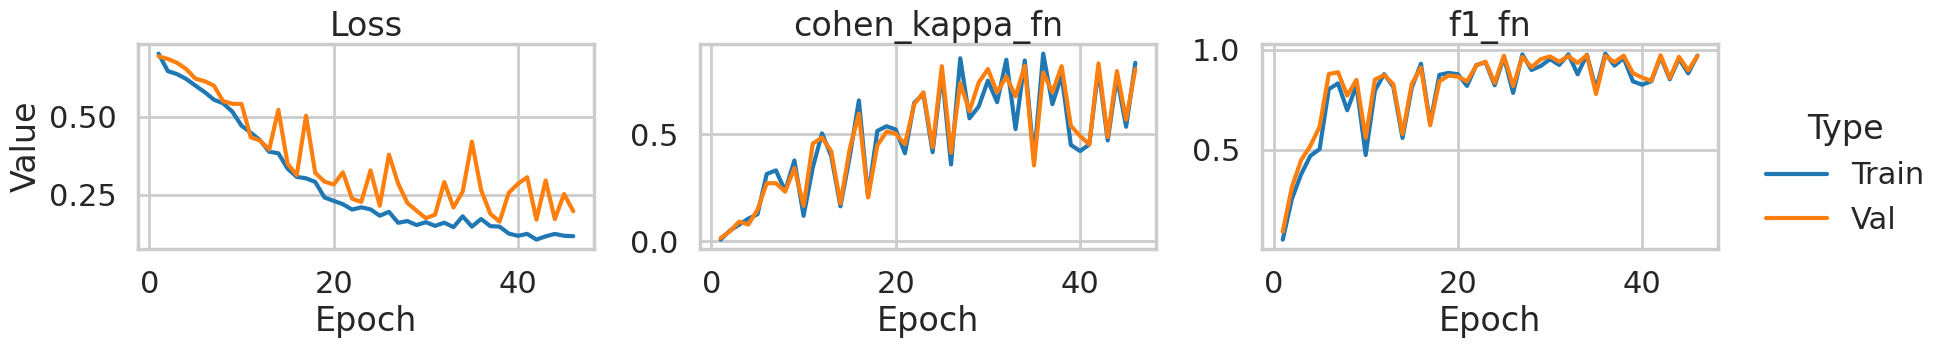

In [47]:
trainer_cnn_4.plot_epochs()

In [48]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1751 | Test cohen_kappa_fn: 0.8350 | Test f1_fn: 0.9740


#### Visualization

In [49]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

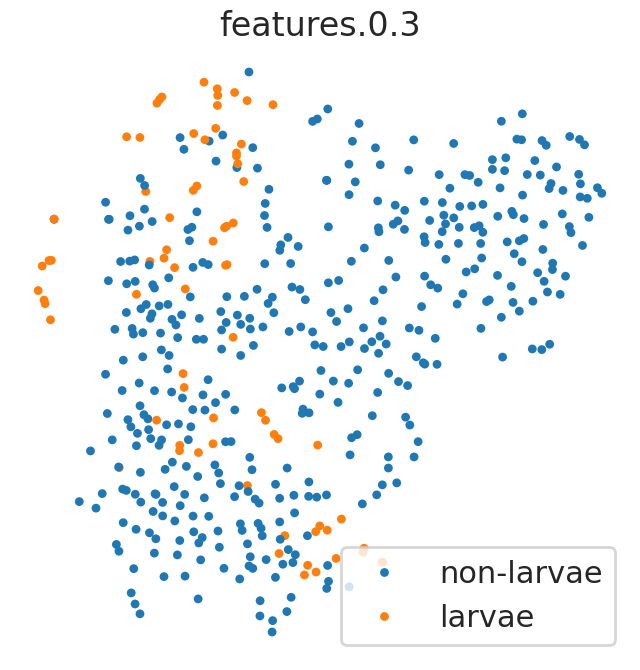

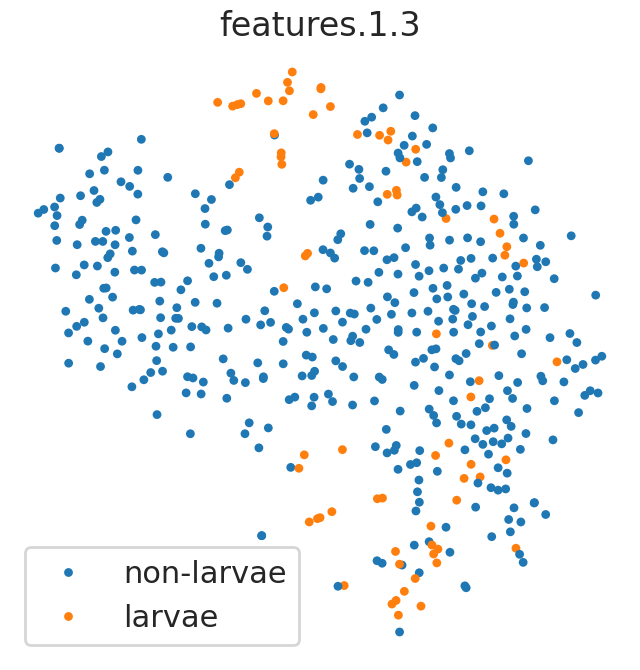

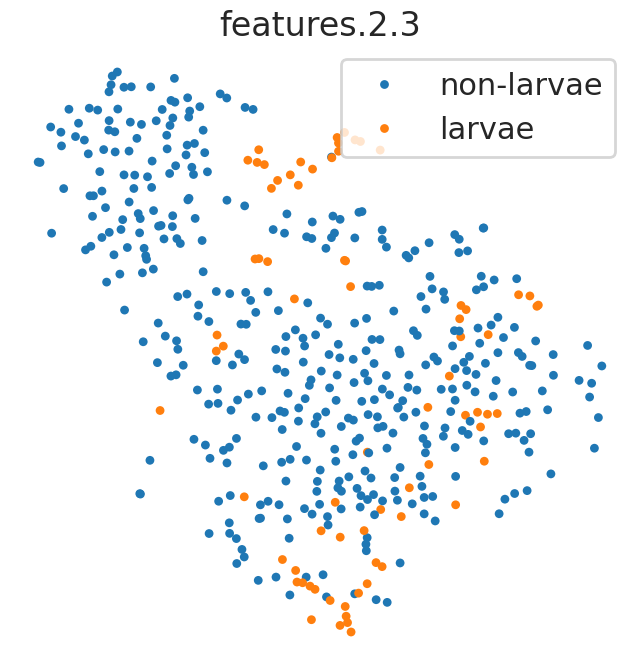

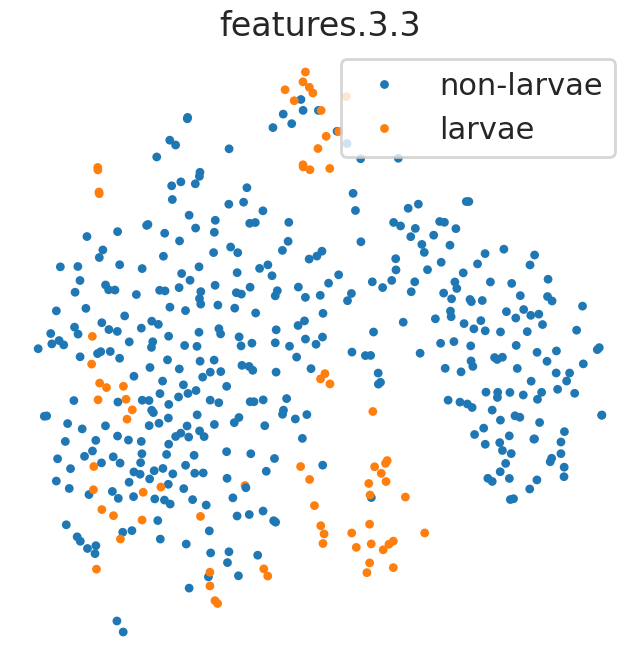

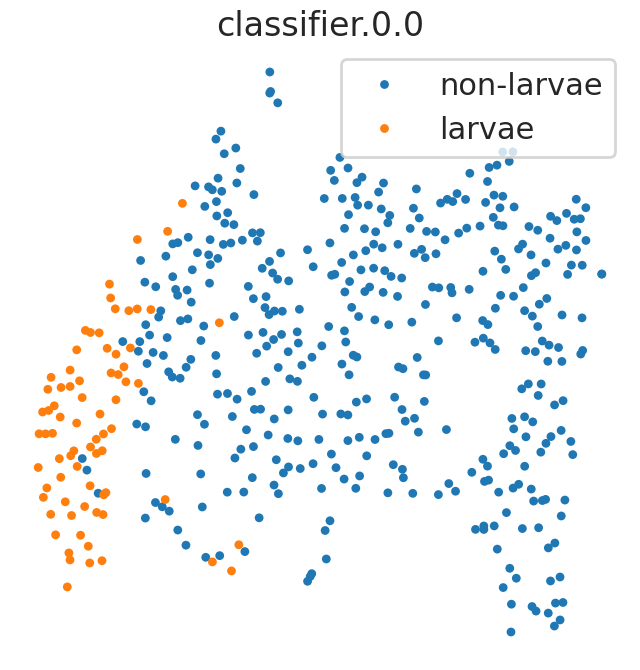

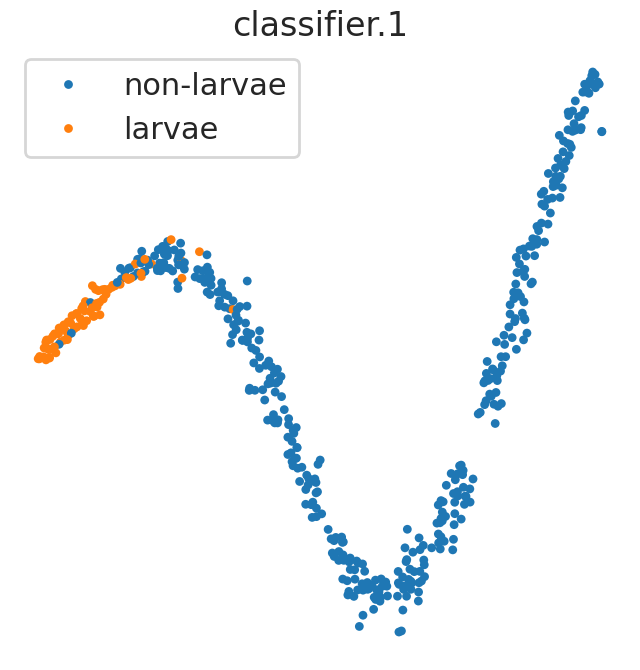

In [50]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


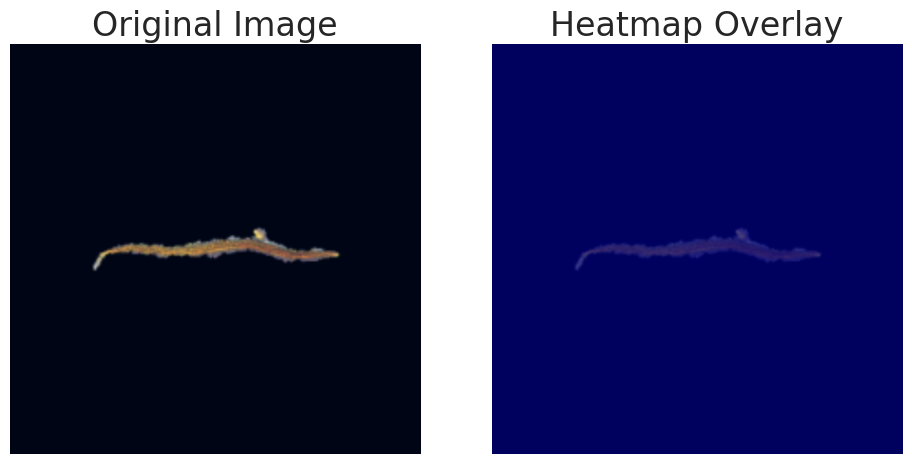

  Generating heatmap for Larvae...
  Predicted label is Larvae!


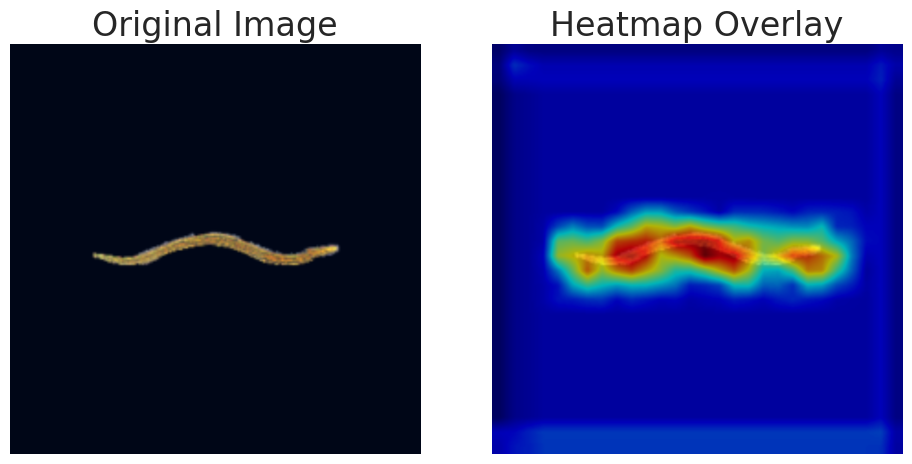

In [51]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [52]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [53]:
optim_config_5 = {
    "lr": 1e-4,
    "scheduler": "plateau",
    "weight_decay": 4e-4,
    "warmup_epochs": 10,
    "eta_min": 1e-6,
    "factor": 0.4,
    "patience": 2,
}
optimizer_cnn_5, scheduler_cnn_5 = build_optimizer_and_scheduler(cnn_5, optim_config_5, total_epochs=100)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [54]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6765 | Val Loss: 0.6886 | Train cohen_kappa_fn: 0.0546 | Val cohen_kappa_fn: -0.0145 | Train f1_fn: 0.8355 | Val f1_fn: 0.9019
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6565 | Val Loss: 0.6806 | Train cohen_kappa_fn: 0.0979 | Val cohen_kappa_fn: 0.0948 | Train f1_fn: 0.4427 | Val f1_fn: 0.5808
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6345 | Val Loss: 0.6722 | Train cohen_kappa_fn: 0.0323 | Val cohen_kappa_fn: 0.0873 | Train f1_fn: 0.1781 | Val f1_fn: 0.4186
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6179 | Val Loss: 0.6508 | Train cohen_kappa_fn: 0.1235 | Val cohen_kappa_fn: 0.1474 | Train f1_fn: 0.4967 | Val f1_fn: 0.6807
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5960 | Val Loss: 0.6399 | Train cohen_kappa_fn: 0.1796 | Val cohen_kappa_fn: 0.2005 | Train f1_fn: 0.6812 | Val f1_fn: 0.8478
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5743 | Val Loss: 0.6011 | Train cohen_kappa_fn: 0.1249 | Val cohen_kappa_fn: 0.1932 | Train f1_fn: 0.5180 | Val f1_fn: 0.7378
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5673 | Val Loss: 0.6343 | Train cohen_kappa_fn: 0.3193 | Val cohen_kappa_fn: 0.1914 | Train f1_fn: 0.8082 | Val f1_fn: 0.8897
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5315 | Val Loss: 0.5523 | Train cohen_kappa_fn: 0.2348 | Val cohen_kappa_fn: 0.3515 | Train f1_fn: 0.6834 | Val f1_fn: 0.8537
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4979 | Val Loss: 0.5844 | Train cohen_kappa_fn: 0.3178 | Val cohen_kappa_fn: 0.2958 | Train f1_fn: 0.8178 | Val f1_fn: 0.8954
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4811 | Val Loss: 0.4818 | Train cohen_kappa_fn: 0.1563 | Val cohen_kappa_fn: 0.2599 | Train f1_fn: 0.5565 | Val f1_fn: 0.7078
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4773 | Val Loss: 0.4595 | Train cohen_kappa_fn: 0.3149 | Val cohen_kappa_fn: 0.4190 | Train f1_fn: 0.7614 | Val f1_fn: 0.8752
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4319 | Val Loss: 0.4541 | Train cohen_kappa_fn: 0.4589 | Val cohen_kappa_fn: 0.4576 | Train f1_fn: 0.8736 | Val f1_fn: 0.9101
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4149 | Val Loss: 0.3888 | Train cohen_kappa_fn: 0.2958 | Val cohen_kappa_fn: 0.4160 | Train f1_fn: 0.7398 | Val f1_fn: 0.8243
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3698 | Val Loss: 0.3656 | Train cohen_kappa_fn: 0.4125 | Val cohen_kappa_fn: 0.4954 | Train f1_fn: 0.8335 | Val f1_fn: 0.8719
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3639 | Val Loss: 0.3427 | Train cohen_kappa_fn: 0.6435 | Val cohen_kappa_fn: 0.6148 | Train f1_fn: 0.9320 | Val f1_fn: 0.9293
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3254 | Val Loss: 0.4184 | Train cohen_kappa_fn: 0.3316 | Val cohen_kappa_fn: 0.2603 | Train f1_fn: 0.7653 | Val f1_fn: 0.6925
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3442 | Val Loss: 0.3108 | Train cohen_kappa_fn: 0.5753 | Val cohen_kappa_fn: 0.5289 | Train f1_fn: 0.9076 | Val f1_fn: 0.8911
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2892 | Val Loss: 0.3462 | Train cohen_kappa_fn: 0.4180 | Val cohen_kappa_fn: 0.4260 | Train f1_fn: 0.8316 | Val f1_fn: 0.8261
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2872 | Val Loss: 0.4824 | Train cohen_kappa_fn: 0.2104 | Val cohen_kappa_fn: 0.2048 | Train f1_fn: 0.6336 | Val f1_fn: 0.6224
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2999 | Val Loss: 0.2897 | Train cohen_kappa_fn: 0.7083 | Val cohen_kappa_fn: 0.6973 | Train f1_fn: 0.9444 | Val f1_fn: 0.9493
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2539 | Val Loss: 0.2755 | Train cohen_kappa_fn: 0.6192 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9172 | Val f1_fn: 0.9389
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2341 | Val Loss: 0.3371 | Train cohen_kappa_fn: 0.7620 | Val cohen_kappa_fn: 0.7653 | Train f1_fn: 0.9620 | Val f1_fn: 0.9651
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2538 | Val Loss: 0.2573 | Train cohen_kappa_fn: 0.6718 | Val cohen_kappa_fn: 0.7149 | Train f1_fn: 0.9324 | Val f1_fn: 0.9486
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.2084 | Val Loss: 0.3534 | Train cohen_kappa_fn: 0.8087 | Val cohen_kappa_fn: 0.7464 | Train f1_fn: 0.9694 | Val f1_fn: 0.9635
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2184 | Val Loss: 0.2564 | Train cohen_kappa_fn: 0.6706 | Val cohen_kappa_fn: 0.6818 | Train f1_fn: 0.9314 | Val f1_fn: 0.9405
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.2378 | Val Loss: 0.2825 | Train cohen_kappa_fn: 0.8003 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9660 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2043 | Val Loss: 0.2555 | Train cohen_kappa_fn: 0.6321 | Val cohen_kappa_fn: 0.6761 | Train f1_fn: 0.9184 | Val f1_fn: 0.9432
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2073 | Val Loss: 0.2691 | Train cohen_kappa_fn: 0.7403 | Val cohen_kappa_fn: 0.7475 | Train f1_fn: 0.9496 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1764 | Val Loss: 0.3819 | Train cohen_kappa_fn: 0.8023 | Val cohen_kappa_fn: 0.7419 | Train f1_fn: 0.9697 | Val f1_fn: 0.9636
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1774 | Val Loss: 0.2775 | Train cohen_kappa_fn: 0.5708 | Val cohen_kappa_fn: 0.5699 | Train f1_fn: 0.8962 | Val f1_fn: 0.9014
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1654 | Val Loss: 0.3692 | Train cohen_kappa_fn: 0.8549 | Val cohen_kappa_fn: 0.7570 | Train f1_fn: 0.9778 | Val f1_fn: 0.9654
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2205 | Val Loss: 0.4092 | Train cohen_kappa_fn: 0.3546 | Val cohen_kappa_fn: 0.3595 | Train f1_fn: 0.7831 | Val f1_fn: 0.7875
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


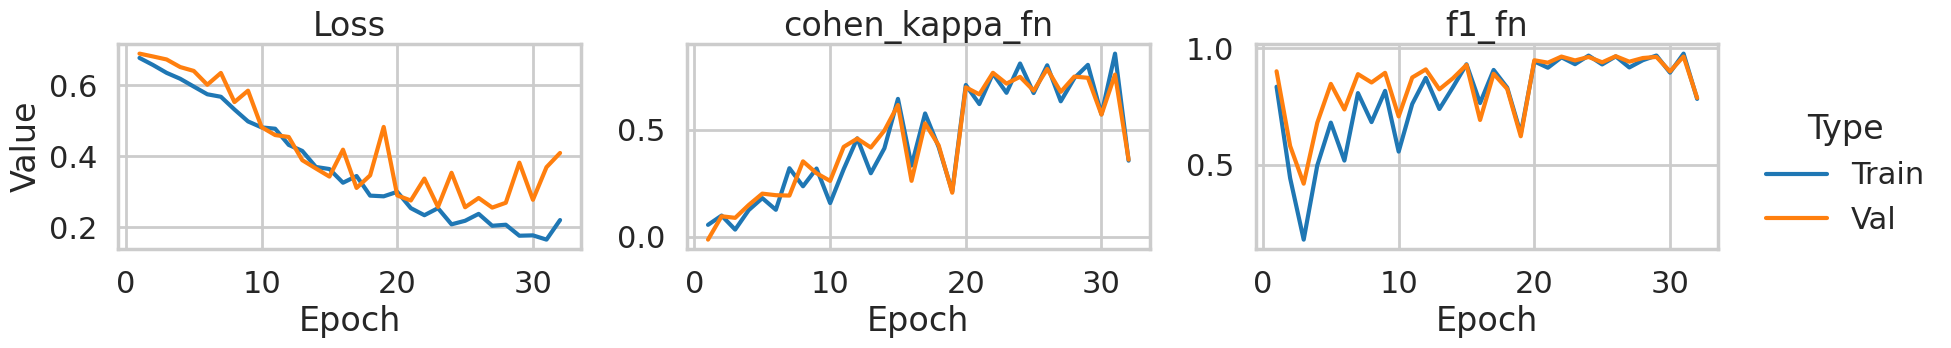

In [55]:
trainer_cnn_5.plot_epochs()

In [56]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2174 | Test cohen_kappa_fn: 0.7470 | Test f1_fn: 0.9559


#### Visualization

In [57]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

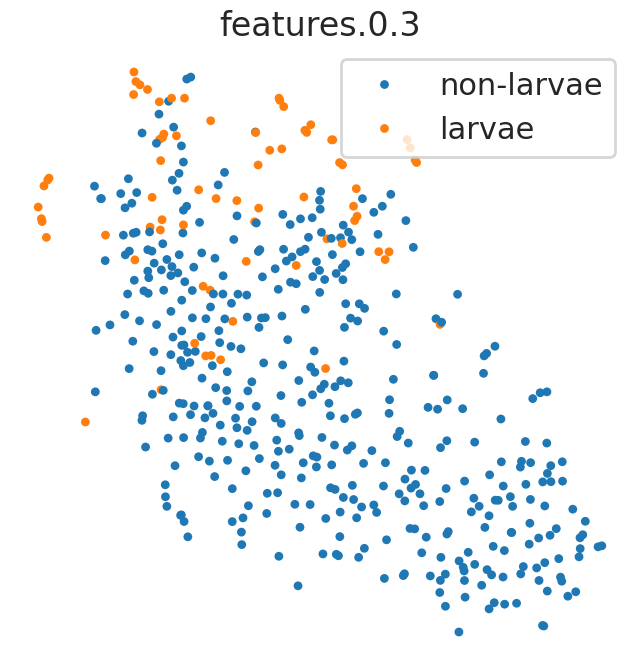

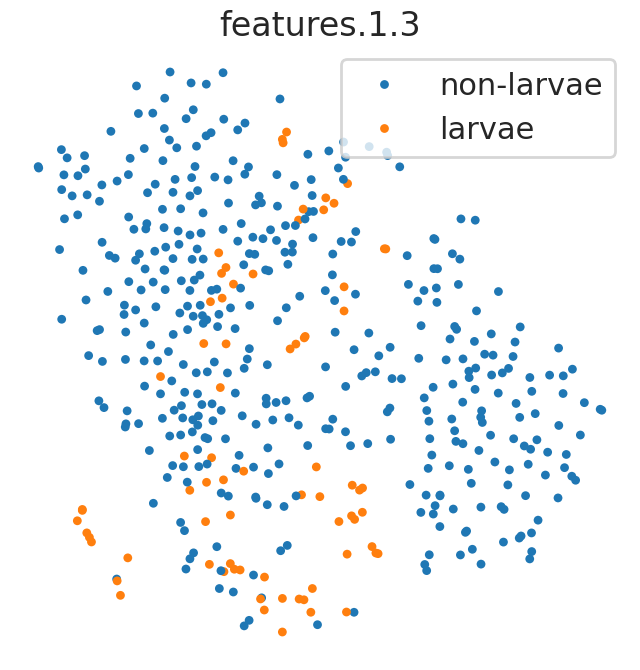

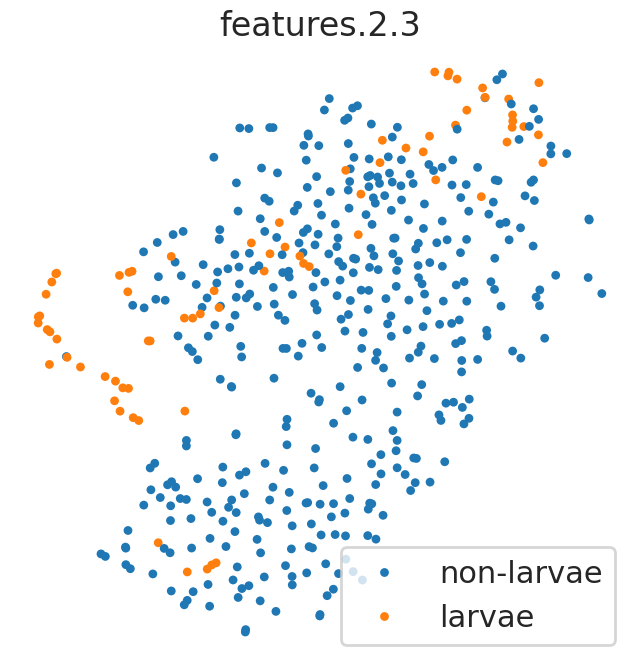

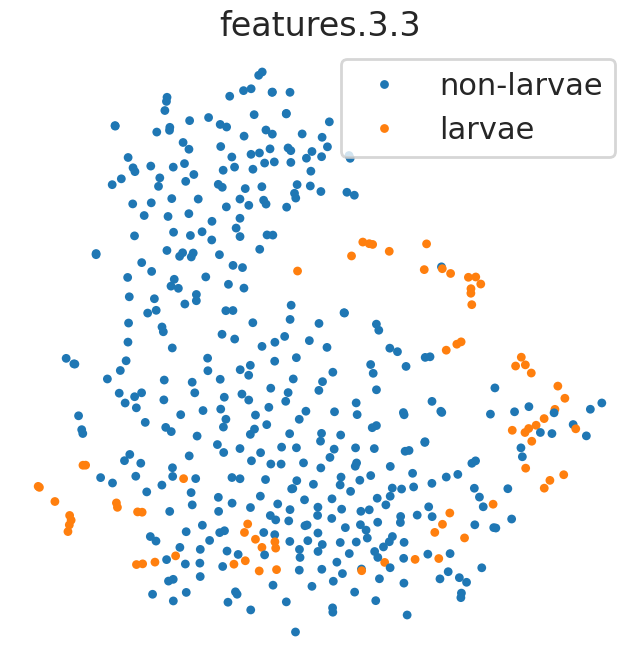

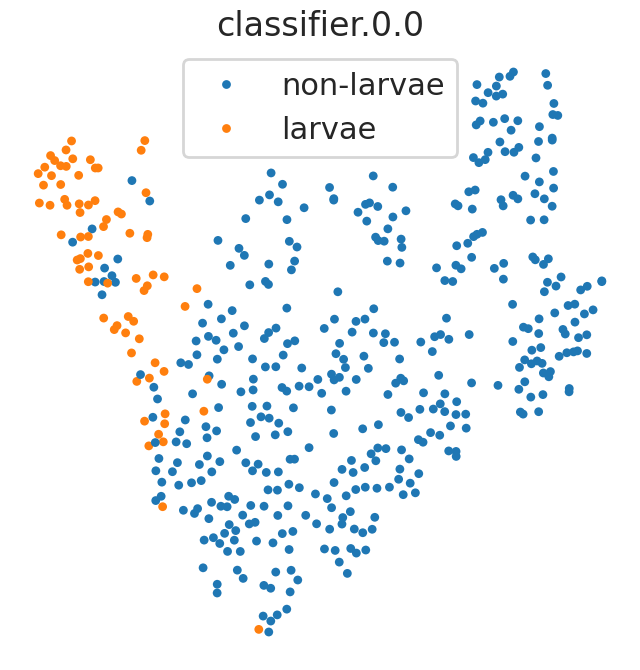

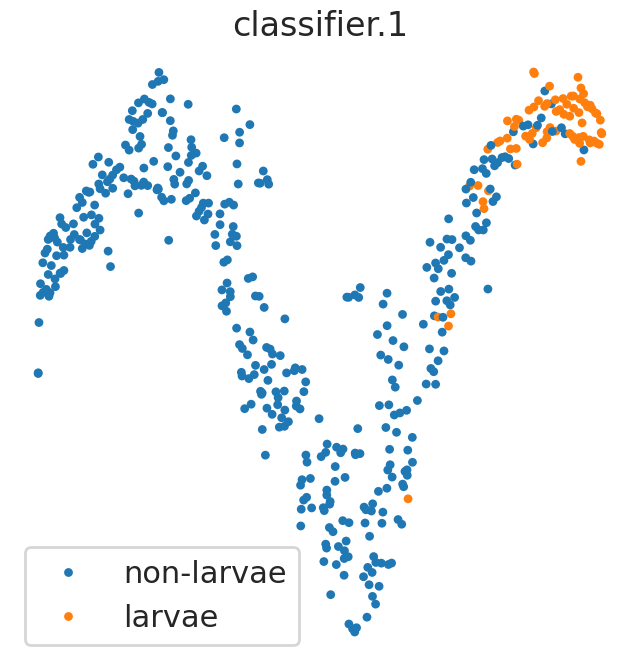

In [58]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


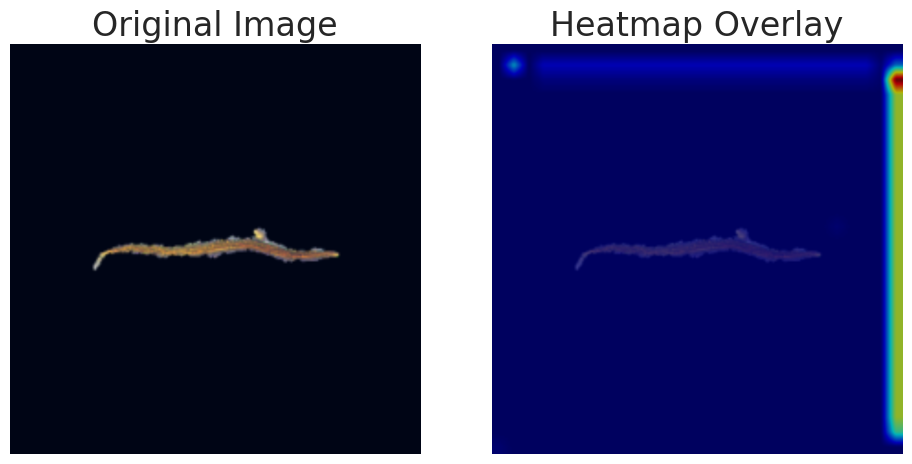

  Generating heatmap for Larvae...
  Predicted label is Larvae!


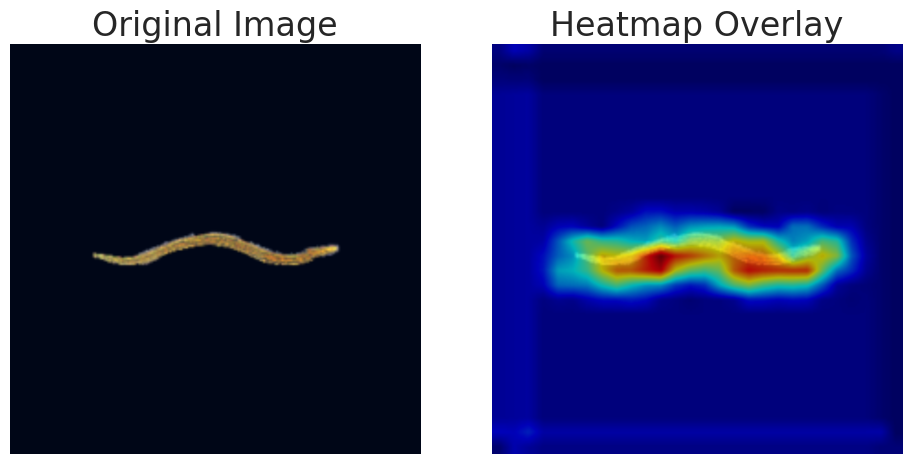

In [59]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [76]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [77]:
optim_config_6 = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 5e-5,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 10,
}
optimizer_cnn_6, scheduler_cnn_6 = build_optimizer_and_scheduler(cnn_6, optim_config_6, train_loader_len=len(train_loader), total_epochs=100)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [78]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6832 | Val Loss: 0.6910 | Train cohen_kappa_fn: 0.0042 | Val cohen_kappa_fn: 0.0119 | Train f1_fn: 0.0574 | Val f1_fn: 0.0714
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6497 | Val Loss: 0.6813 | Train cohen_kappa_fn: 0.0253 | Val cohen_kappa_fn: 0.0925 | Train f1_fn: 0.1941 | Val f1_fn: 0.4848
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6352 | Val Loss: 0.6670 | Train cohen_kappa_fn: 0.0328 | Val cohen_kappa_fn: 0.1157 | Train f1_fn: 0.2042 | Val f1_fn: 0.5041
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6022 | Val Loss: 0.6438 | Train cohen_kappa_fn: 0.0427 | Val cohen_kappa_fn: 0.1802 | Train f1_fn: 0.2679 | Val f1_fn: 0.6504
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5820 | Val Loss: 0.6180 | Train cohen_kappa_fn: 0.1529 | Val cohen_kappa_fn: 0.3025 | Train f1_fn: 0.6339 | Val f1_fn: 0.8719
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5749 | Val Loss: 0.6028 | Train cohen_kappa_fn: 0.2219 | Val cohen_kappa_fn: 0.2906 | Train f1_fn: 0.7392 | Val f1_fn: 0.9022
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5342 | Val Loss: 0.5652 | Train cohen_kappa_fn: 0.1926 | Val cohen_kappa_fn: 0.3324 | Train f1_fn: 0.6813 | Val f1_fn: 0.8872
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5442 | Val Loss: 0.5438 | Train cohen_kappa_fn: 0.2622 | Val cohen_kappa_fn: 0.4145 | Train f1_fn: 0.7514 | Val f1_fn: 0.9094
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5237 | Val Loss: 0.5221 | Train cohen_kappa_fn: 0.3067 | Val cohen_kappa_fn: 0.4440 | Train f1_fn: 0.8000 | Val f1_fn: 0.9174
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5024 | Val Loss: 0.4924 | Train cohen_kappa_fn: 0.3697 | Val cohen_kappa_fn: 0.4862 | Train f1_fn: 0.8155 | Val f1_fn: 0.9205
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4947 | Val Loss: 0.4414 | Train cohen_kappa_fn: 0.2219 | Val cohen_kappa_fn: 0.4051 | Train f1_fn: 0.6789 | Val f1_fn: 0.8347
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4547 | Val Loss: 0.4959 | Train cohen_kappa_fn: 0.4286 | Val cohen_kappa_fn: 0.5443 | Train f1_fn: 0.8891 | Val f1_fn: 0.9365
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.4390 | Val Loss: 0.4138 | Train cohen_kappa_fn: 0.2598 | Val cohen_kappa_fn: 0.4007 | Train f1_fn: 0.7139 | Val f1_fn: 0.8323
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.4303 | Val Loss: 0.4027 | Train cohen_kappa_fn: 0.3974 | Val cohen_kappa_fn: 0.5242 | Train f1_fn: 0.8352 | Val f1_fn: 0.9070
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.4072 | Val Loss: 0.3981 | Train cohen_kappa_fn: 0.5119 | Val cohen_kappa_fn: 0.6296 | Train f1_fn: 0.8921 | Val f1_fn: 0.9427
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.4068 | Val Loss: 0.3481 | Train cohen_kappa_fn: 0.3616 | Val cohen_kappa_fn: 0.4779 | Train f1_fn: 0.7965 | Val f1_fn: 0.8735
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3697 | Val Loss: 0.3950 | Train cohen_kappa_fn: 0.6516 | Val cohen_kappa_fn: 0.6745 | Train f1_fn: 0.9403 | Val f1_fn: 0.9546
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.3320 | Val Loss: 0.3308 | Train cohen_kappa_fn: 0.4350 | Val cohen_kappa_fn: 0.4785 | Train f1_fn: 0.8441 | Val f1_fn: 0.8706
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3271 | Val Loss: 0.3285 | Train cohen_kappa_fn: 0.6569 | Val cohen_kappa_fn: 0.6225 | Train f1_fn: 0.9313 | Val f1_fn: 0.9313
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.3099 | Val Loss: 0.3095 | Train cohen_kappa_fn: 0.6653 | Val cohen_kappa_fn: 0.5676 | Train f1_fn: 0.9318 | Val f1_fn: 0.9094
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2832 | Val Loss: 0.2987 | Train cohen_kappa_fn: 0.7249 | Val cohen_kappa_fn: 0.6329 | Train f1_fn: 0.9494 | Val f1_fn: 0.9356
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2679 | Val Loss: 0.2763 | Train cohen_kappa_fn: 0.6375 | Val cohen_kappa_fn: 0.5742 | Train f1_fn: 0.9243 | Val f1_fn: 0.9116
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2430 | Val Loss: 0.2688 | Train cohen_kappa_fn: 0.6131 | Val cohen_kappa_fn: 0.5656 | Train f1_fn: 0.9145 | Val f1_fn: 0.9044
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.2334 | Val Loss: 0.2434 | Train cohen_kappa_fn: 0.7083 | Val cohen_kappa_fn: 0.6545 | Train f1_fn: 0.9434 | Val f1_fn: 0.9394
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2229 | Val Loss: 0.2693 | Train cohen_kappa_fn: 0.8215 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9708 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2398 | Val Loss: 0.2587 | Train cohen_kappa_fn: 0.4979 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.8667 | Val f1_fn: 0.8974
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2068 | Val Loss: 0.2698 | Train cohen_kappa_fn: 0.8315 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9732 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1826 | Val Loss: 0.2669 | Train cohen_kappa_fn: 0.5234 | Val cohen_kappa_fn: 0.5345 | Train f1_fn: 0.8791 | Val f1_fn: 0.8907
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1879 | Val Loss: 0.2515 | Train cohen_kappa_fn: 0.6467 | Val cohen_kappa_fn: 0.6613 | Train f1_fn: 0.9237 | Val f1_fn: 0.9367
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


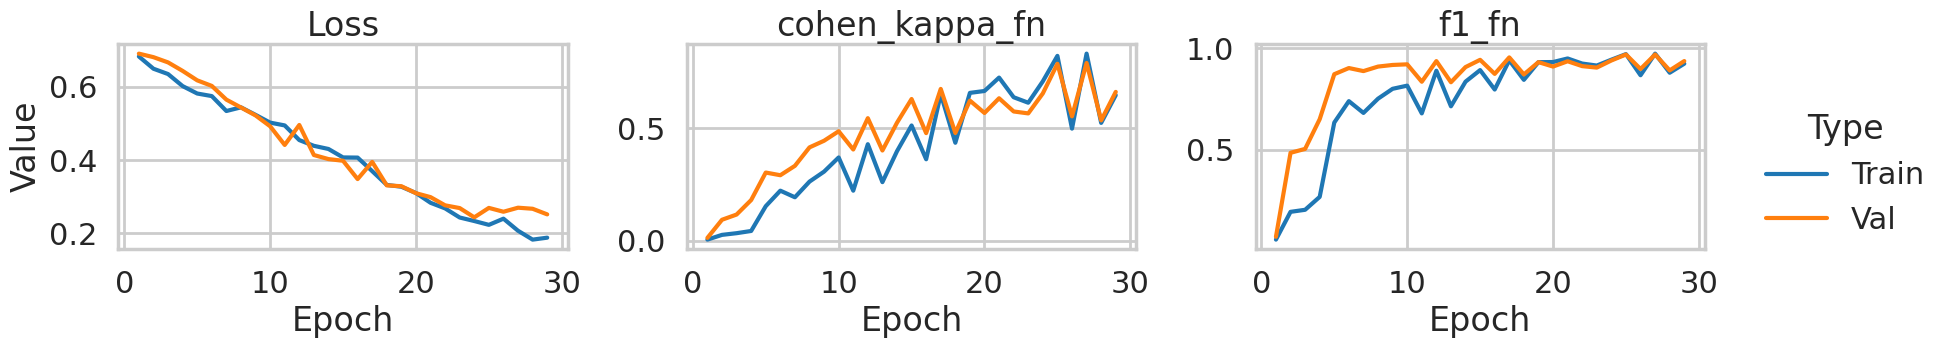

In [79]:
trainer_cnn_6.plot_epochs()

In [80]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2440 | Test cohen_kappa_fn: 0.7753 | Test f1_fn: 0.9625


#### Visualization

In [81]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

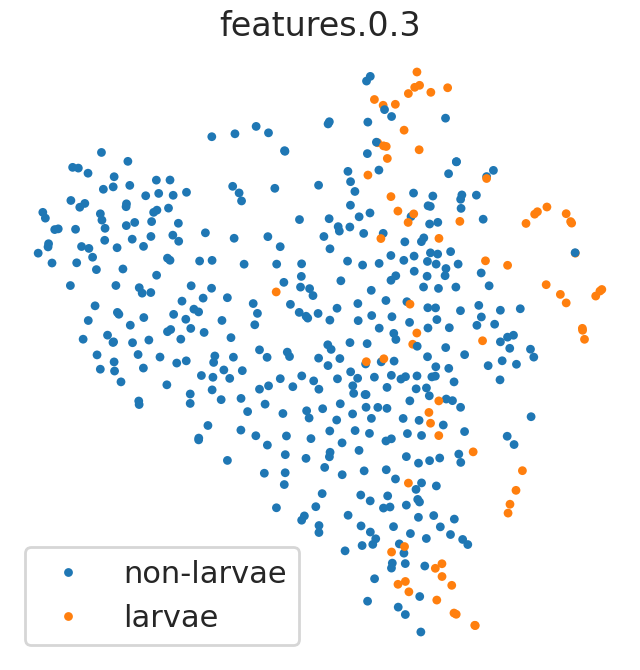

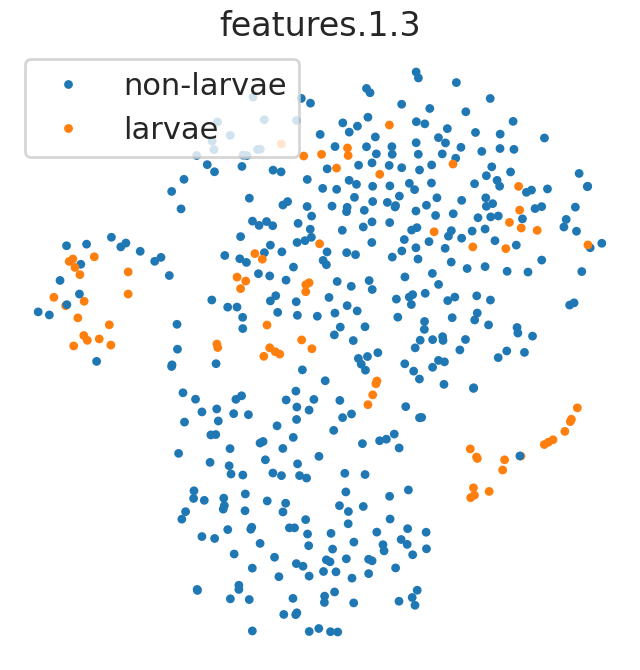

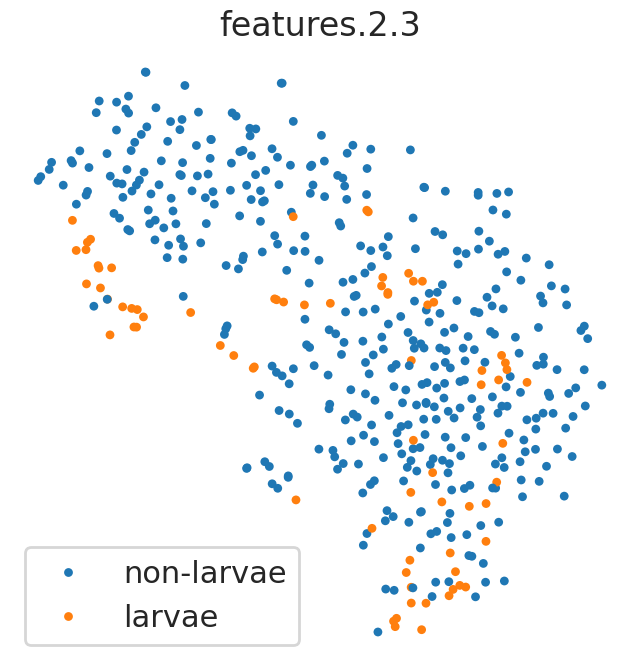

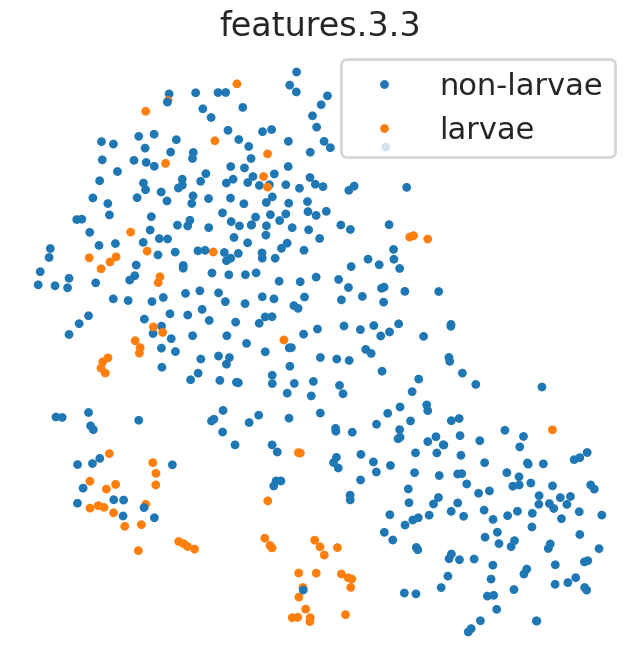

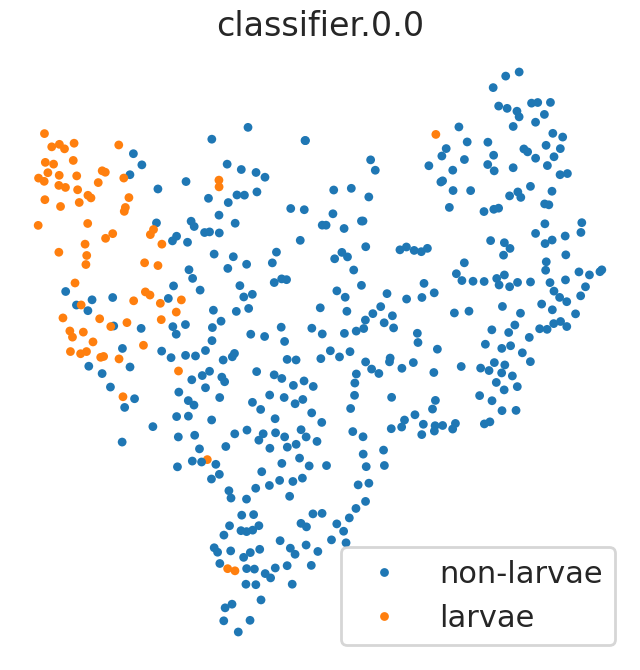

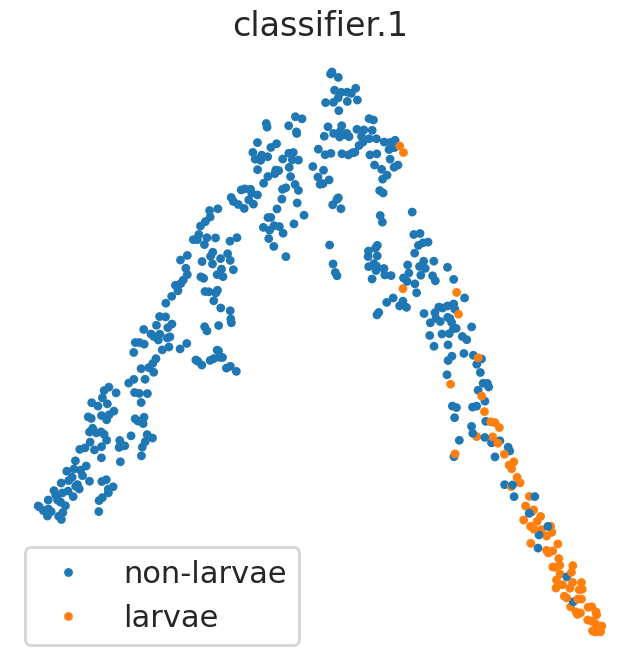

In [82]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


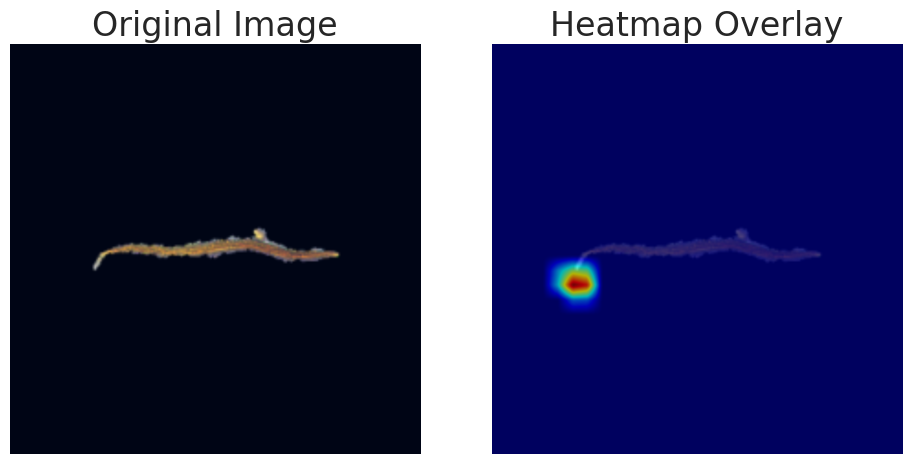

  Generating heatmap for Larvae...
  Predicted label is Larvae!


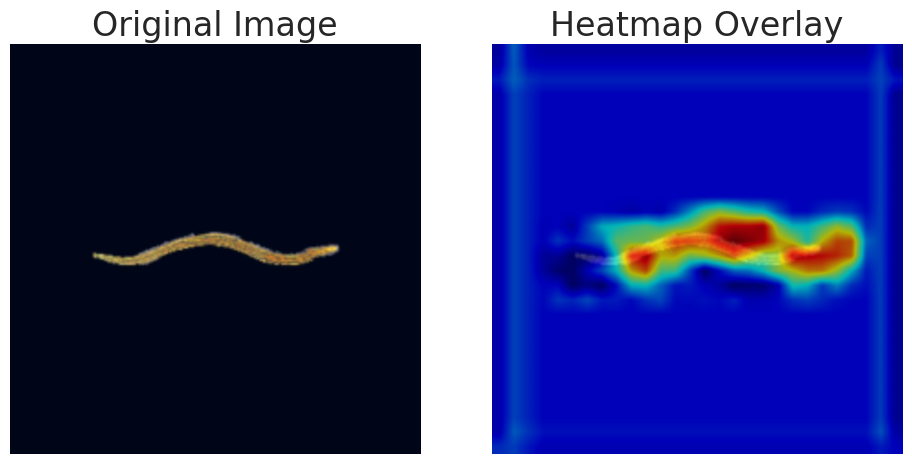

In [83]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [84]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [85]:
optim_config_7 = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 10,
}
optimizer_cnn_7, scheduler_cnn_7 = build_optimizer_and_scheduler(cnn_7, optim_config_7, train_loader_len=len(train_loader), total_epochs=100)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [86]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=100)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.7282 | Val Loss: 0.6967 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6909 | Val Loss: 0.6877 | Train cohen_kappa_fn: 0.0494 | Val cohen_kappa_fn: 0.1161 | Train f1_fn: 0.3418 | Val f1_fn: 0.6158
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6558 | Val Loss: 0.6768 | Train cohen_kappa_fn: 0.1609 | Val cohen_kappa_fn: 0.1160 | Train f1_fn: 0.7211 | Val f1_fn: 0.8226
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6281 | Val Loss: 0.6552 | Train cohen_kappa_fn: 0.1019 | Val cohen_kappa_fn: 0.2016 | Train f1_fn: 0.5065 | Val f1_fn: 0.7126
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6220 | Val Loss: 0.6283 | Train cohen_kappa_fn: 0.1456 | Val cohen_kappa_fn: 0.2717 | Train f1_fn: 0.5893 | Val f1_fn: 0.7871
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5871 | Val Loss: 0.6181 | Train cohen_kappa_fn: 0.2902 | Val cohen_kappa_fn: 0.2574 | Train f1_fn: 0.8250 | Val f1_fn: 0.9009
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5596 | Val Loss: 0.5586 | Train cohen_kappa_fn: 0.2178 | Val cohen_kappa_fn: 0.3184 | Train f1_fn: 0.6920 | Val f1_fn: 0.8374
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5459 | Val Loss: 0.5274 | Train cohen_kappa_fn: 0.2542 | Val cohen_kappa_fn: 0.3340 | Train f1_fn: 0.7266 | Val f1_fn: 0.8361
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4958 | Val Loss: 0.5004 | Train cohen_kappa_fn: 0.3229 | Val cohen_kappa_fn: 0.4191 | Train f1_fn: 0.8041 | Val f1_fn: 0.8854
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4793 | Val Loss: 0.4492 | Train cohen_kappa_fn: 0.1801 | Val cohen_kappa_fn: 0.2839 | Train f1_fn: 0.6108 | Val f1_fn: 0.7173
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4522 | Val Loss: 0.4047 | Train cohen_kappa_fn: 0.3841 | Val cohen_kappa_fn: 0.4879 | Train f1_fn: 0.8259 | Val f1_fn: 0.8835
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4383 | Val Loss: 0.3759 | Train cohen_kappa_fn: 0.3755 | Val cohen_kappa_fn: 0.4957 | Train f1_fn: 0.8209 | Val f1_fn: 0.8690
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3938 | Val Loss: 0.3667 | Train cohen_kappa_fn: 0.3576 | Val cohen_kappa_fn: 0.4203 | Train f1_fn: 0.7958 | Val f1_fn: 0.8268
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3772 | Val Loss: 0.3300 | Train cohen_kappa_fn: 0.4784 | Val cohen_kappa_fn: 0.5226 | Train f1_fn: 0.8742 | Val f1_fn: 0.8807
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3489 | Val Loss: 0.3222 | Train cohen_kappa_fn: 0.5213 | Val cohen_kappa_fn: 0.4759 | Train f1_fn: 0.8860 | Val f1_fn: 0.8565
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3259 | Val Loss: 0.3017 | Train cohen_kappa_fn: 0.6481 | Val cohen_kappa_fn: 0.5338 | Train f1_fn: 0.9287 | Val f1_fn: 0.8852
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3309 | Val Loss: 0.2985 | Train cohen_kappa_fn: 0.6808 | Val cohen_kappa_fn: 0.5117 | Train f1_fn: 0.9389 | Val f1_fn: 0.8760
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3070 | Val Loss: 0.3262 | Train cohen_kappa_fn: 0.5837 | Val cohen_kappa_fn: 0.3966 | Train f1_fn: 0.9071 | Val f1_fn: 0.8079
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2546 | Val Loss: 0.2937 | Train cohen_kappa_fn: 0.6701 | Val cohen_kappa_fn: 0.5015 | Train f1_fn: 0.9325 | Val f1_fn: 0.8655
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2555 | Val Loss: 0.3190 | Train cohen_kappa_fn: 0.5620 | Val cohen_kappa_fn: 0.4007 | Train f1_fn: 0.8947 | Val f1_fn: 0.8106
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2296 | Val Loss: 0.3105 | Train cohen_kappa_fn: 0.5668 | Val cohen_kappa_fn: 0.4348 | Train f1_fn: 0.8965 | Val f1_fn: 0.8312
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2538 | Val Loss: 0.2376 | Train cohen_kappa_fn: 0.7502 | Val cohen_kappa_fn: 0.6381 | Train f1_fn: 0.9520 | Val f1_fn: 0.9255
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2096 | Val Loss: 0.2326 | Train cohen_kappa_fn: 0.7100 | Val cohen_kappa_fn: 0.6675 | Train f1_fn: 0.9413 | Val f1_fn: 0.9339
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1940 | Val Loss: 0.2591 | Train cohen_kappa_fn: 0.8572 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9768 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1844 | Val Loss: 0.2097 | Train cohen_kappa_fn: 0.7178 | Val cohen_kappa_fn: 0.6985 | Train f1_fn: 0.9438 | Val f1_fn: 0.9421
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1729 | Val Loss: 0.1957 | Train cohen_kappa_fn: 0.7440 | Val cohen_kappa_fn: 0.7902 | Train f1_fn: 0.9514 | Val f1_fn: 0.9642
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.1666 | Val Loss: 0.2059 | Train cohen_kappa_fn: 0.6597 | Val cohen_kappa_fn: 0.6836 | Train f1_fn: 0.9270 | Val f1_fn: 0.9354
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1410 | Val Loss: 0.2549 | Train cohen_kappa_fn: 0.8605 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9776 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1693 | Val Loss: 0.1978 | Train cohen_kappa_fn: 0.5853 | Val cohen_kappa_fn: 0.6762 | Train f1_fn: 0.9015 | Val f1_fn: 0.9333
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1312 | Val Loss: 0.3018 | Train cohen_kappa_fn: 0.9058 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9851 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1635 | Val Loss: 0.1894 | Train cohen_kappa_fn: 0.7928 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9626 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.1111 | Val Loss: 0.3903 | Train cohen_kappa_fn: 0.8936 | Val cohen_kappa_fn: 0.7373 | Train f1_fn: 0.9837 | Val f1_fn: 0.9638
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1363 | Val Loss: 0.1832 | Train cohen_kappa_fn: 0.8181 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9672 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.1336 | Val Loss: 0.1621 | Train cohen_kappa_fn: 0.7727 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9577 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.1168 | Val Loss: 0.2477 | Train cohen_kappa_fn: 0.8905 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9820 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1140 | Val Loss: 0.1826 | Train cohen_kappa_fn: 0.8633 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9766 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.0891 | Val Loss: 0.2674 | Train cohen_kappa_fn: 0.9119 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9858 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1049 | Val Loss: 0.2271 | Train cohen_kappa_fn: 0.9125 | Val cohen_kappa_fn: 0.8072 | Train f1_fn: 0.9858 | Val f1_fn: 0.9705
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.0865 | Val Loss: 0.1861 | Train cohen_kappa_fn: 0.8641 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9765 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


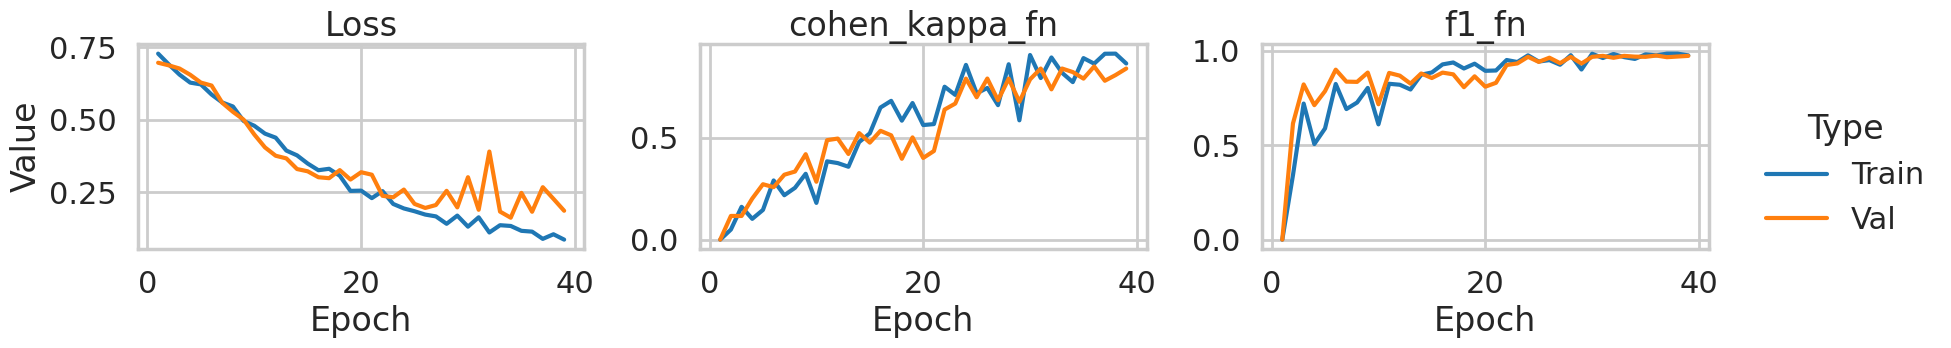

In [87]:
trainer_cnn_7.plot_epochs()

In [88]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1410 | Test cohen_kappa_fn: 0.8706 | Test f1_fn: 0.9788


#### Visualization

In [89]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

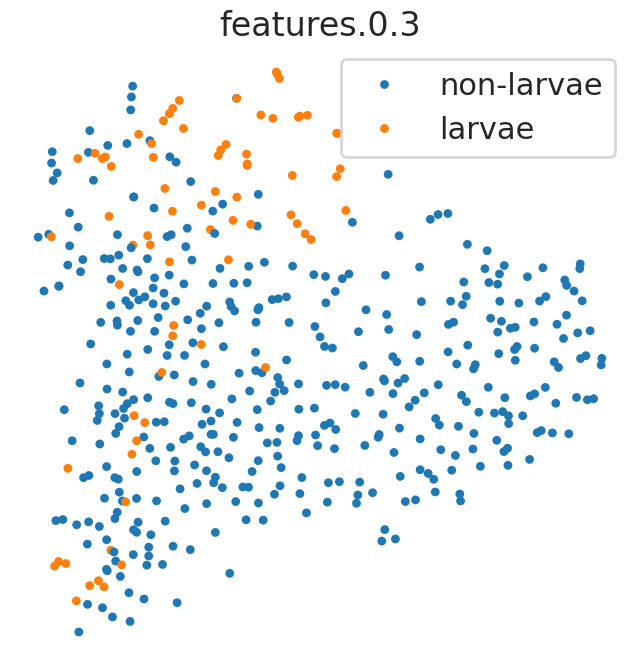

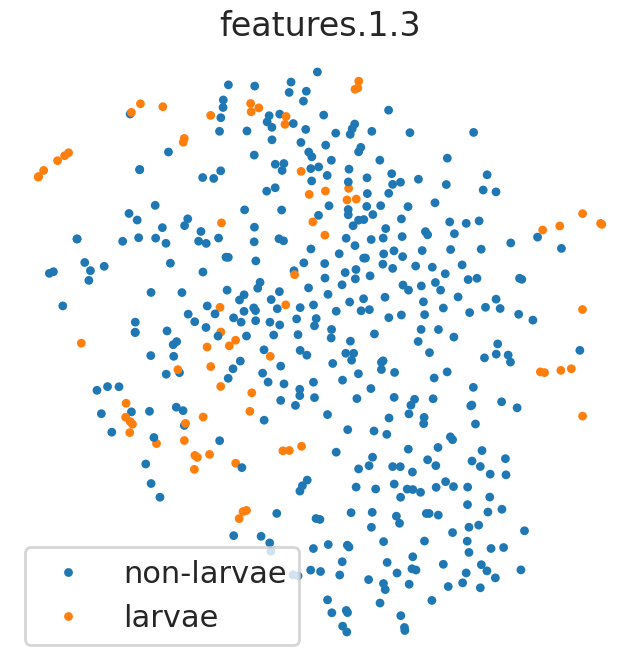

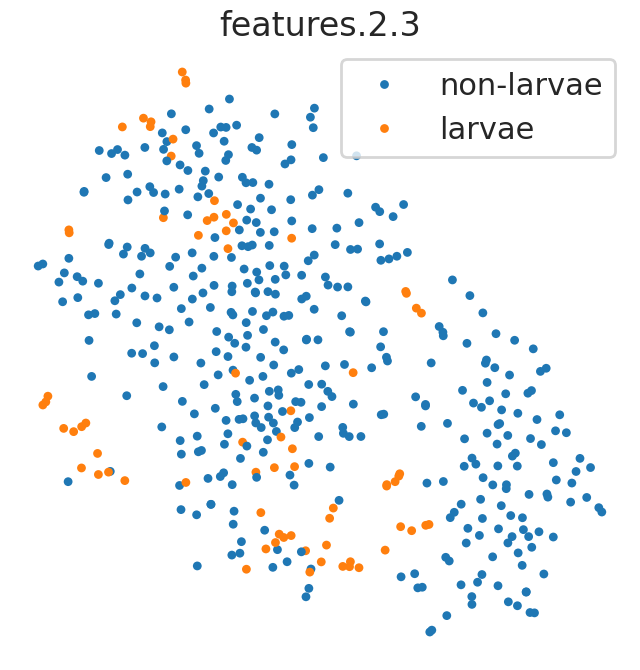

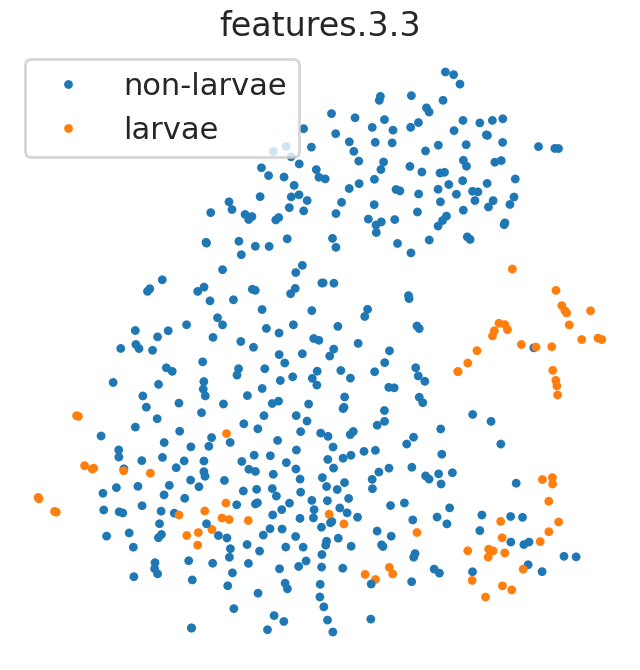

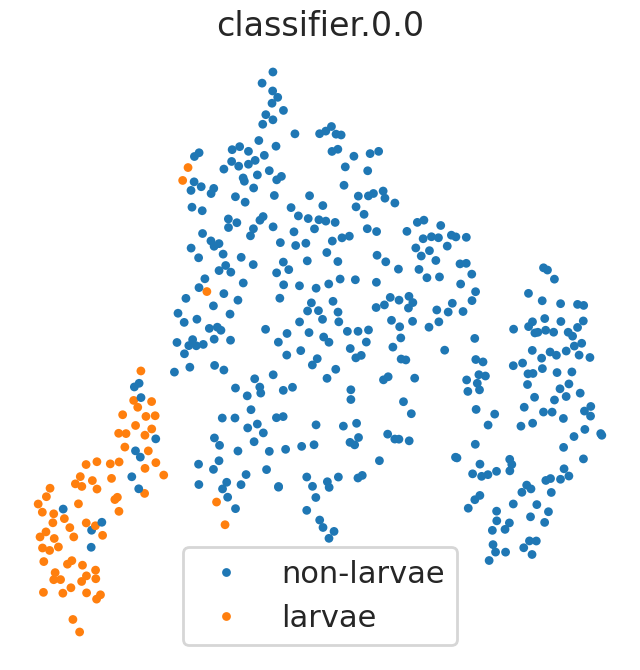

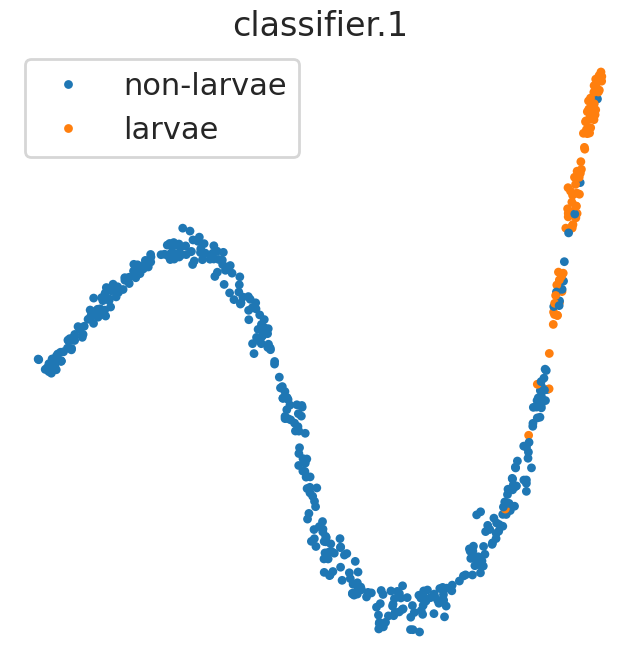

In [90]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


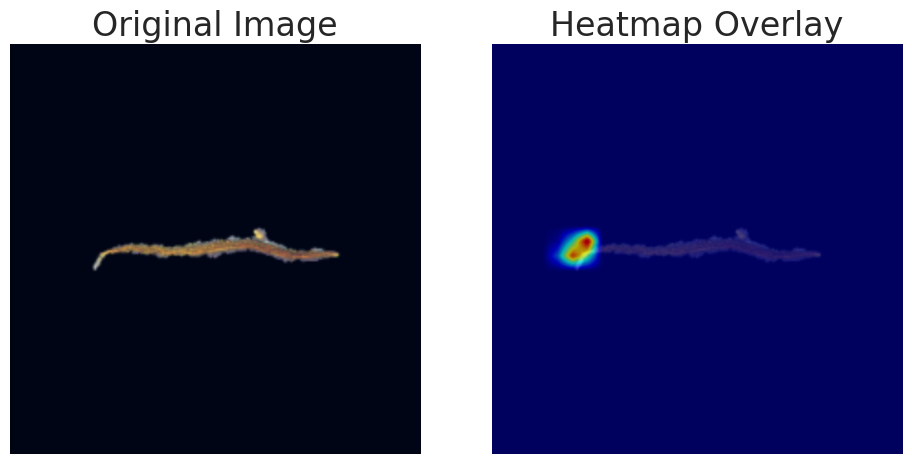

  Generating heatmap for Larvae...
  Predicted label is Larvae!


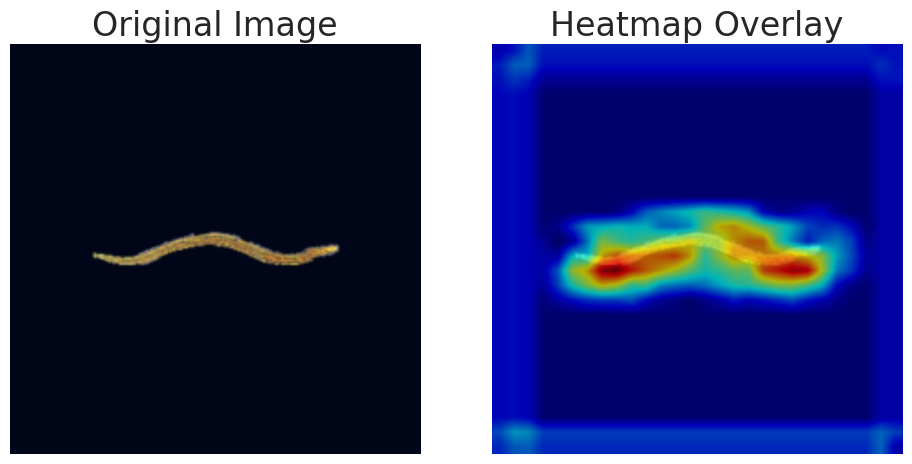

In [91]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break